In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme('paper')


import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #显示负号
%config InlineBackend.figure_format = 'retina'
# plt.style.use('ggplot')
# plt.rcParams['text.usetex'] = True

from scipy.signal import find_peaks
# from scipy.optimize import curve_fit
from lmfit.models import GaussianModel,LorentzianModel,VoigtModel

import os
path='./figs/'
os.makedirs(path,exist_ok=True)

# 示波器波形

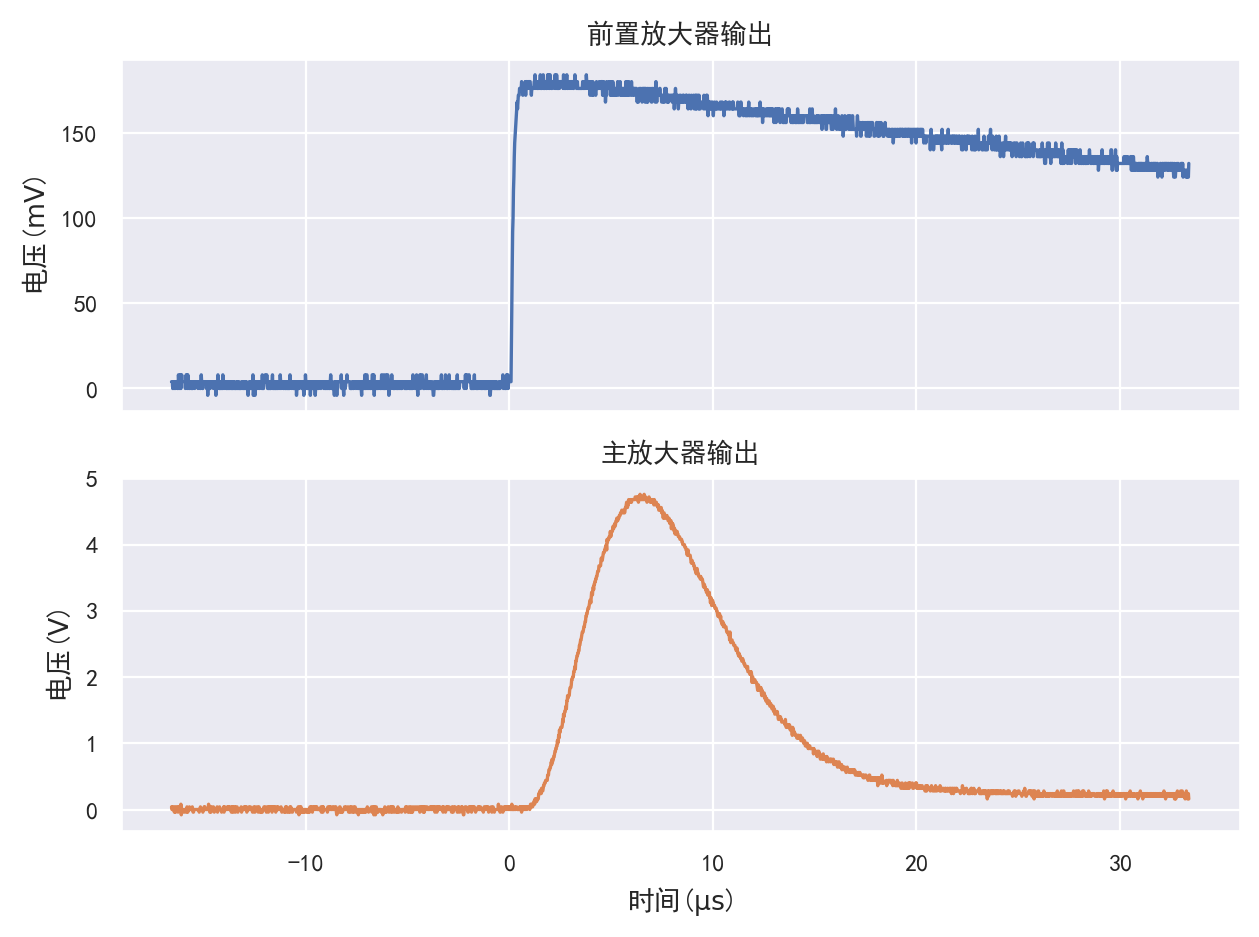

In [2]:
CH1 = pd.read_csv('./data/TEK0000.CSV',header=None)
CH2 = pd.read_csv('./data/TEK0001.CSV',header=None)
oscilloscope = pd.DataFrame({'T_data':CH1[3]*1e6,
                             'CH1_data':CH1[4]*1e3,
                             'CH2_data':CH2[4]})
axes = oscilloscope.plot(x = 'T_data',subplots = True,legend=False)
fig = axes[0].get_figure()
axes[-1].set_xlabel(r'时间(${\rm \mu s}$)')
axes[0].set_ylabel(r'电压(${\rm mV}$)')
axes[0].set_title('前置放大器输出')
axes[1].set_ylabel(r'电压(${\rm V}$)')
axes[1].set_title('主放大器输出')
fig.tight_layout()
fig.savefig(path + 'oscilloscope.pdf')

# 获得最佳分辨率

In [3]:
datapath ='./data/zxtql/'
files = os.listdir(datapath)

txtfiles = []
for file in files:
    _,extension= os.path.splitext(file)
    if extension=='.txt':
        txtfiles.append(file)

txtfiles.sort(key = lambda x:eval(os.path.splitext(x)[0]))
txtfiles

['5.txt',
 '10.txt',
 '20.txt',
 '30.txt',
 '60.txt',
 '80.txt',
 '100.txt',
 '120.txt']

In [4]:
data_dict = {eval(os.path.splitext(txtfile)[0]):pd.read_csv(datapath+txtfile, sep='\t')['1'].values \
             for txtfile in txtfiles}
data1 = pd.DataFrame(data_dict)
data1

,5,10,20,30,60,80,100,120
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1019,0,0,0,0,0,0,0,0
1020,0,0,0,0,0,0,0,0
1021,0,0,0,0,0,0,0,0
1022,0,0,0,0,0,0,0,0


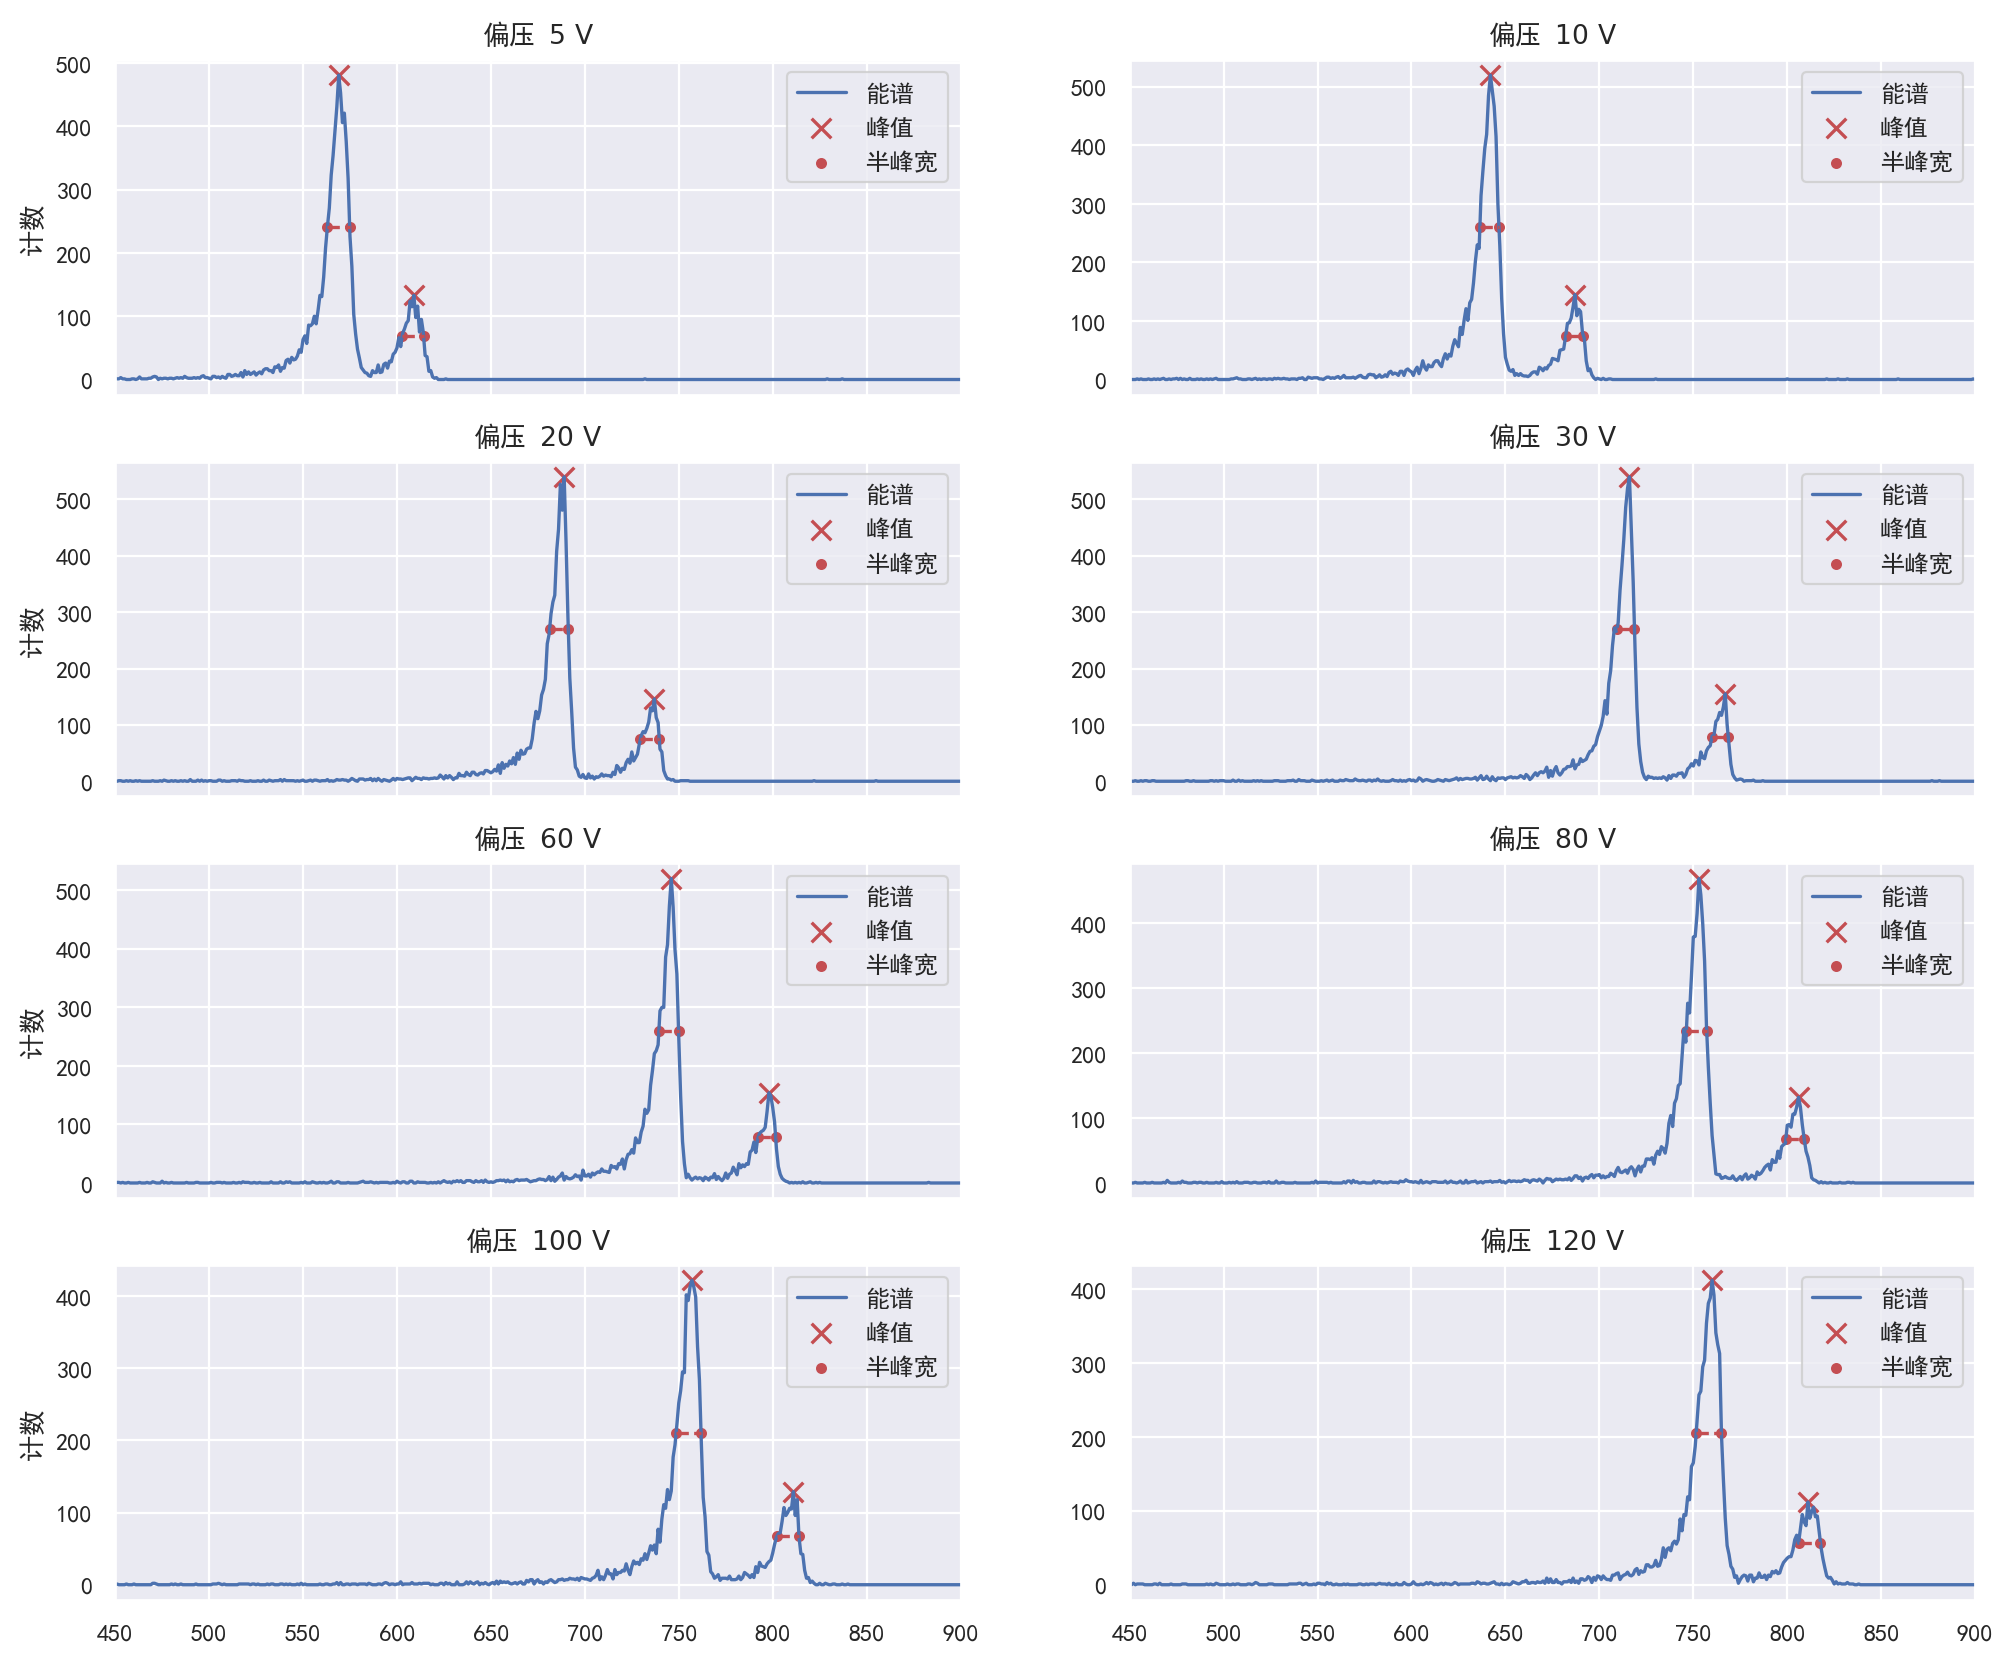

In [5]:
axes = data1.plot(subplots=True,layout=(4,2),figsize=(12,10),color = 'b')
axes = axes.flatten()
axes[0].set_xlim([450,900])

peaks = []
widths = []
for i,(col,ax) in enumerate(zip(data1.columns,axes)):
    # peak analysis
    peak,info = find_peaks(data1[col],
                           height=100,
                           width = 8)
    peaks.append(peak[0])
    widths.append(info['widths'][0])

    # ploting
    ax.scatter(peak,data1[col][peak],marker='x',s=50,color='r',label='peak')
    ax.scatter(info['left_ips'],info['width_heights'],s=10,color='r')
    ax.scatter(info['right_ips'],info['width_heights'],s=10,color='r')
    ax.hlines(info['width_heights'],info['left_ips'],info['right_ips'],
              linestyles = 'dashed',color='r',label = 'FWHM')
    ax.legend(['能谱','峰值','半峰宽'])
    ax.set_title(fr'偏压 ${col}~{{\rm V}}$')
    if i%2 == 0:
        ax.set_ylabel('计数')

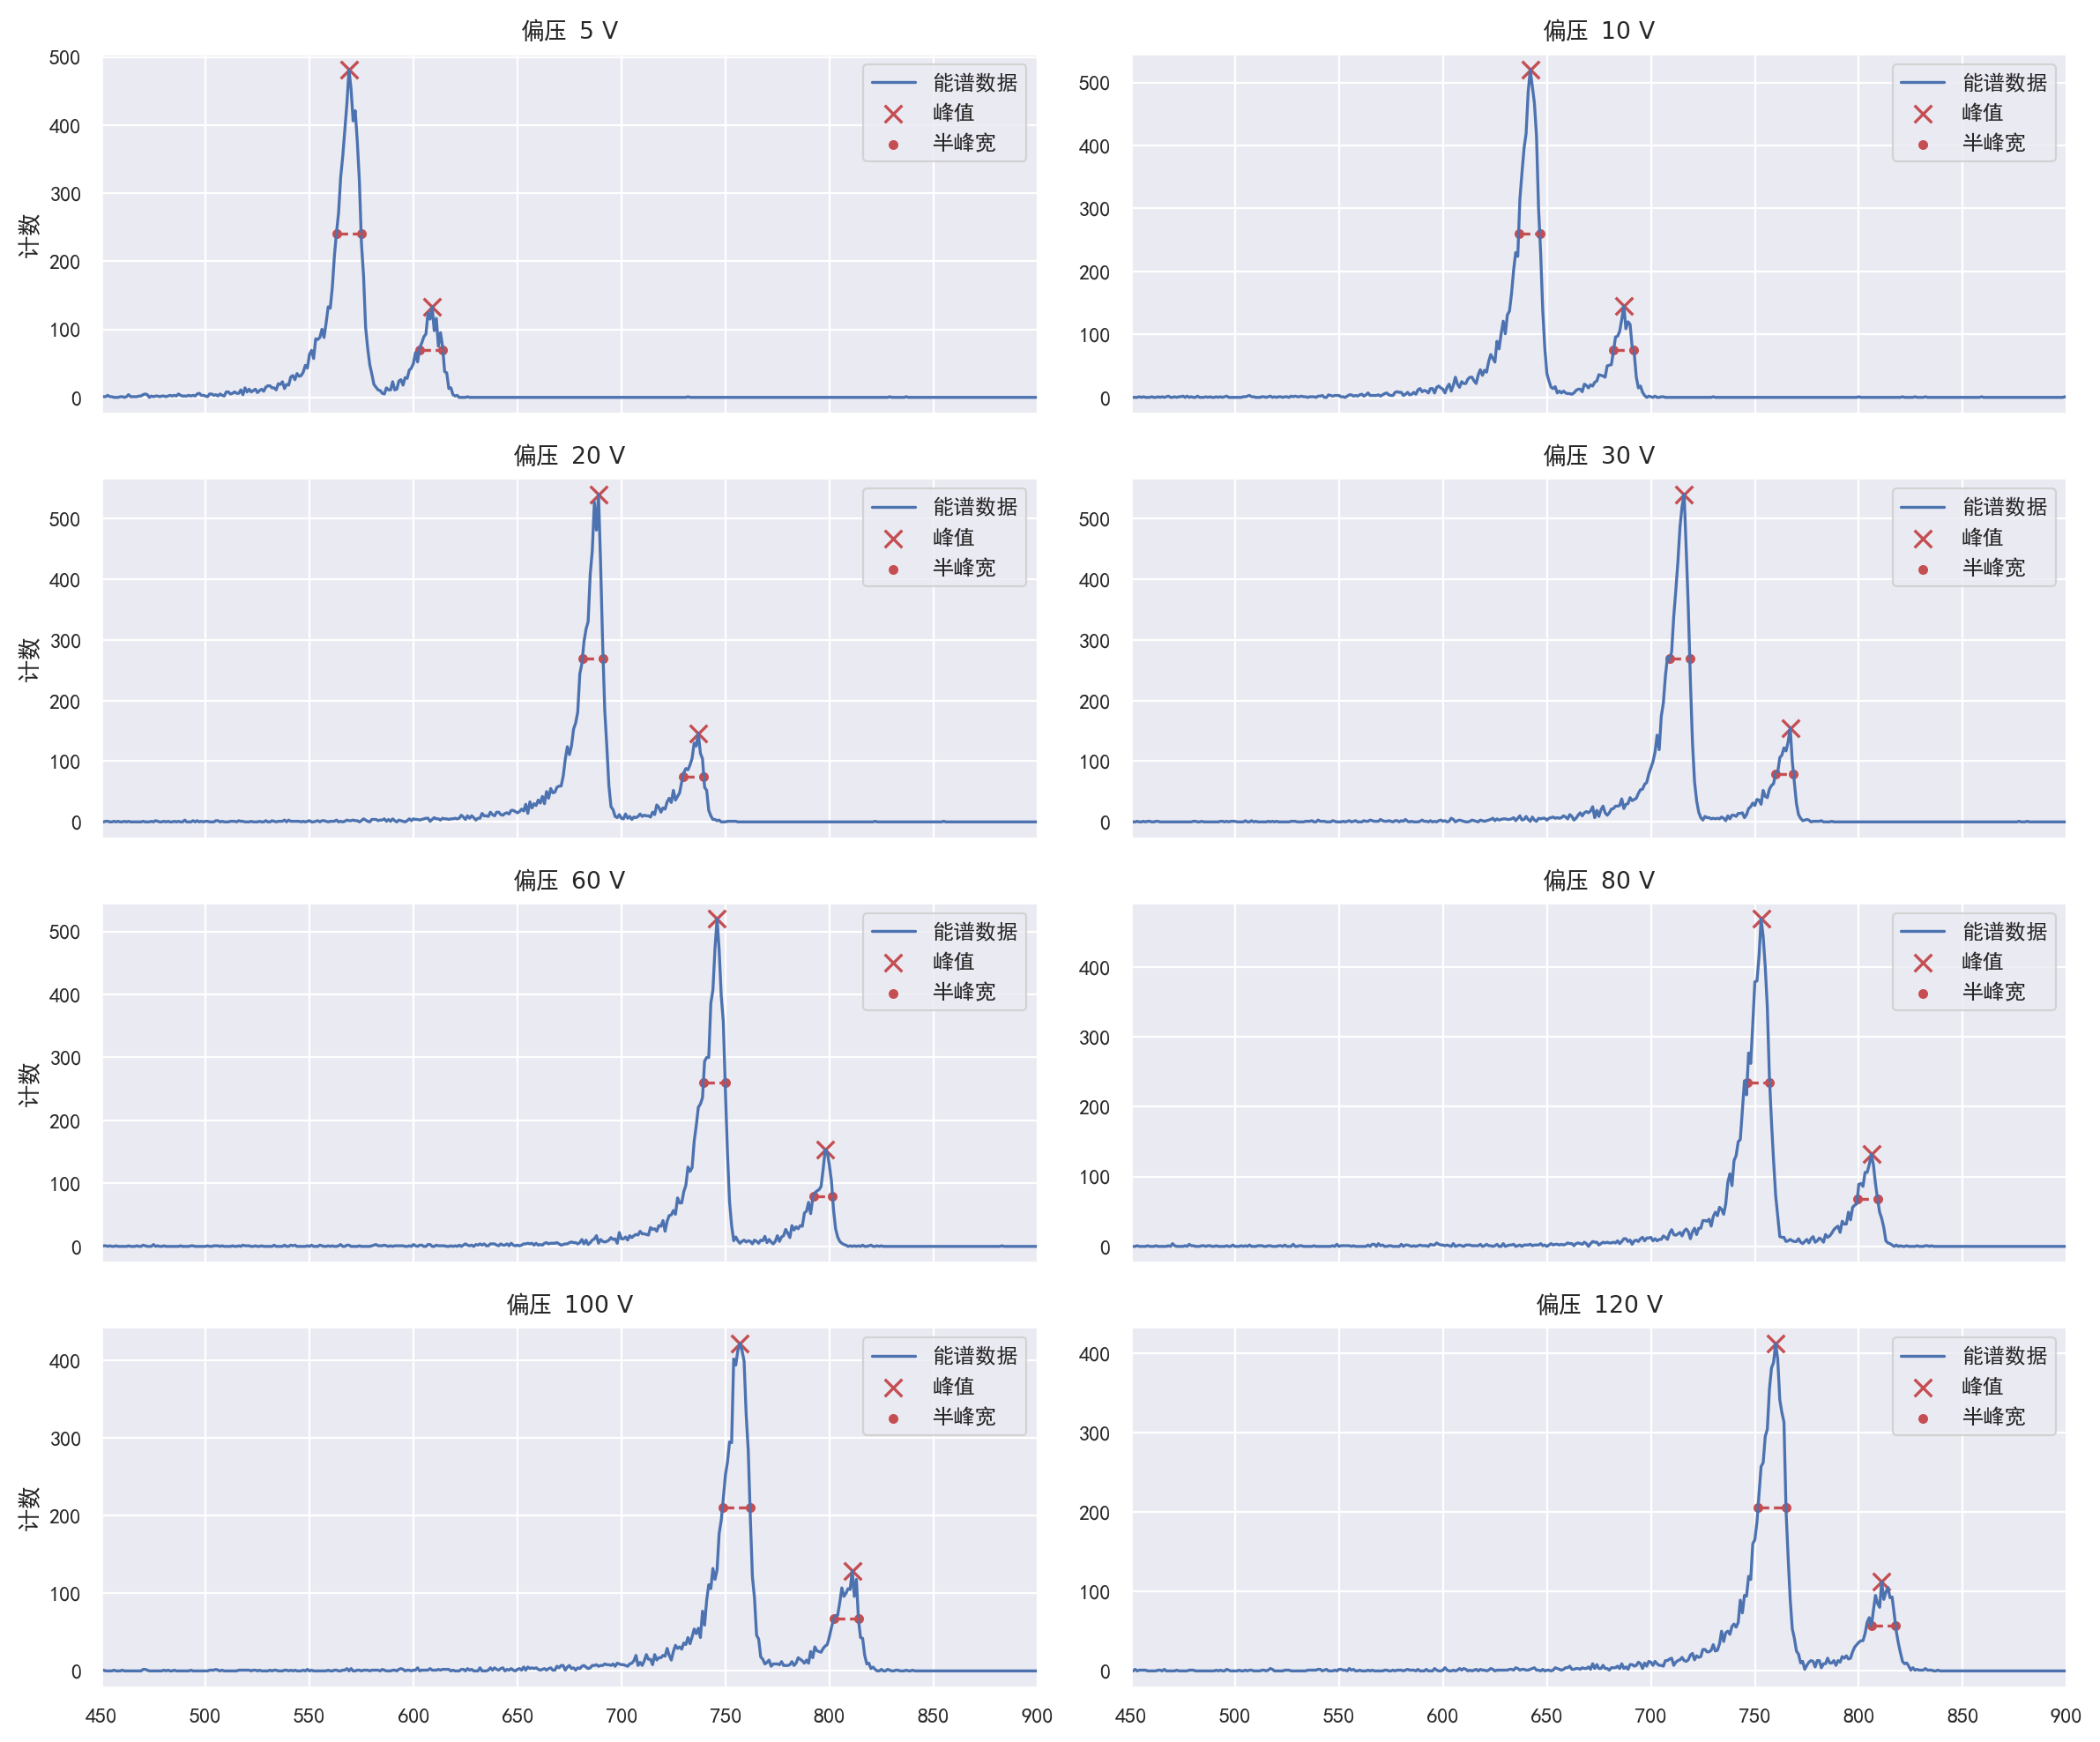

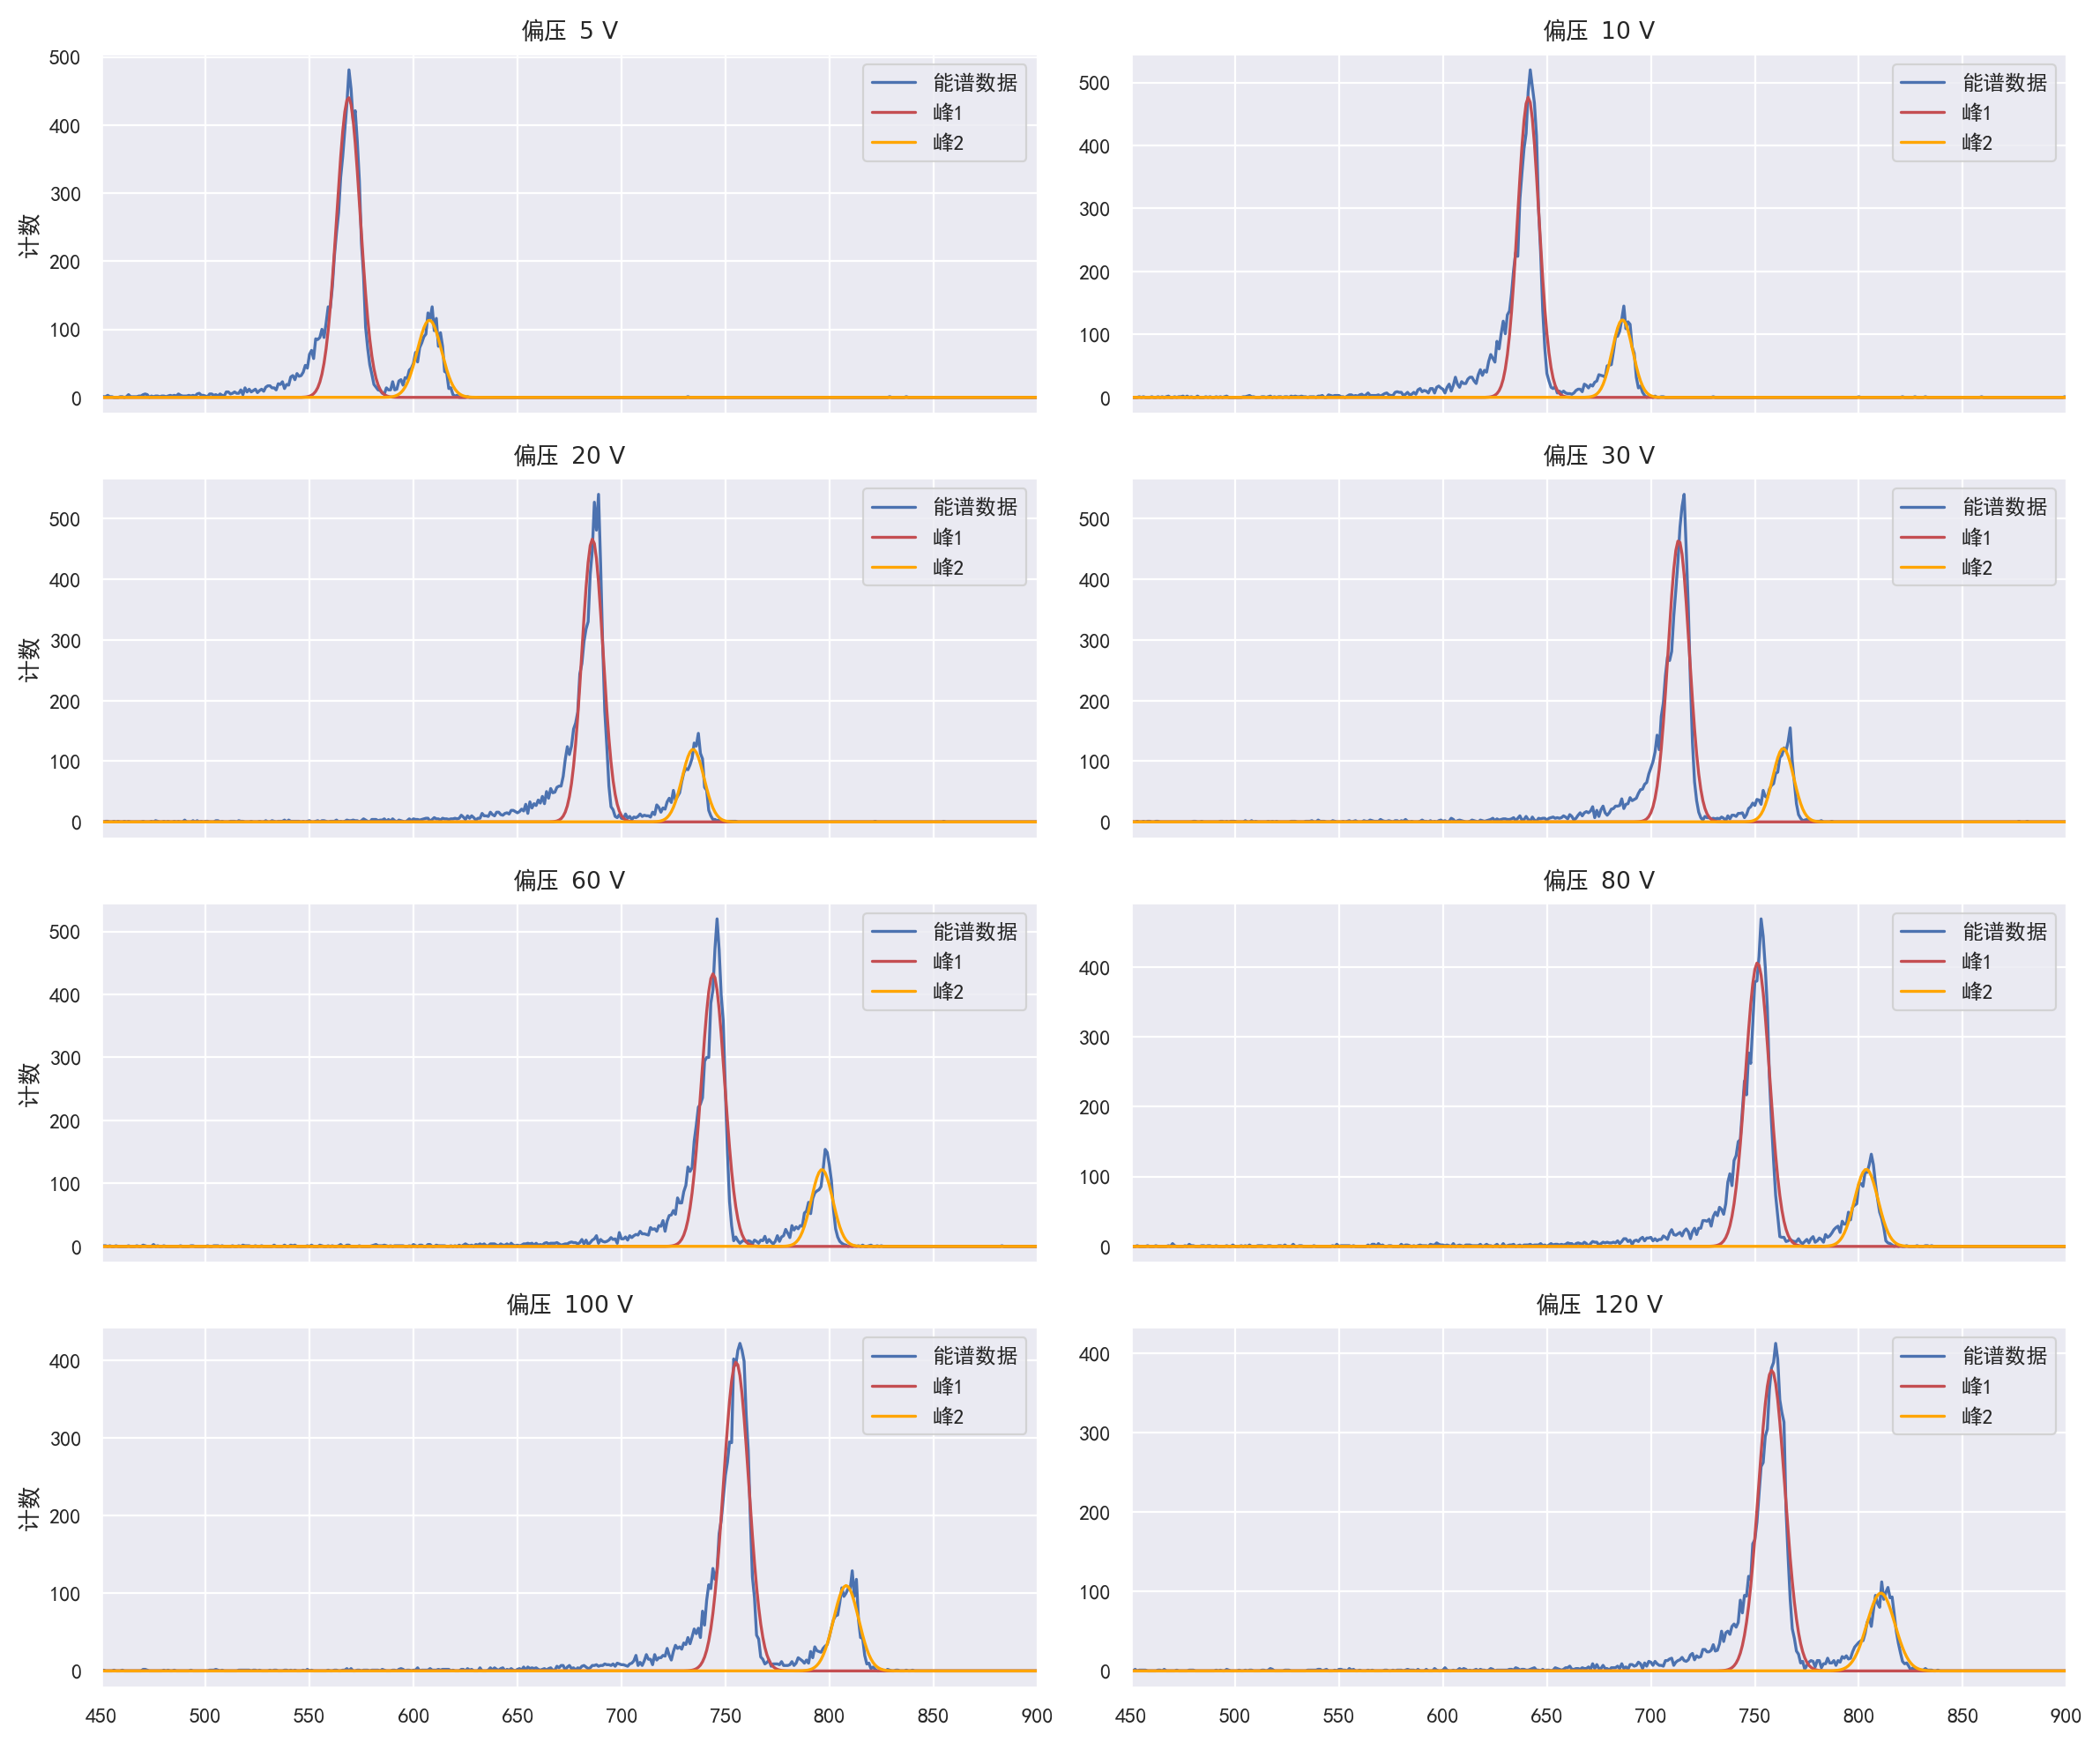

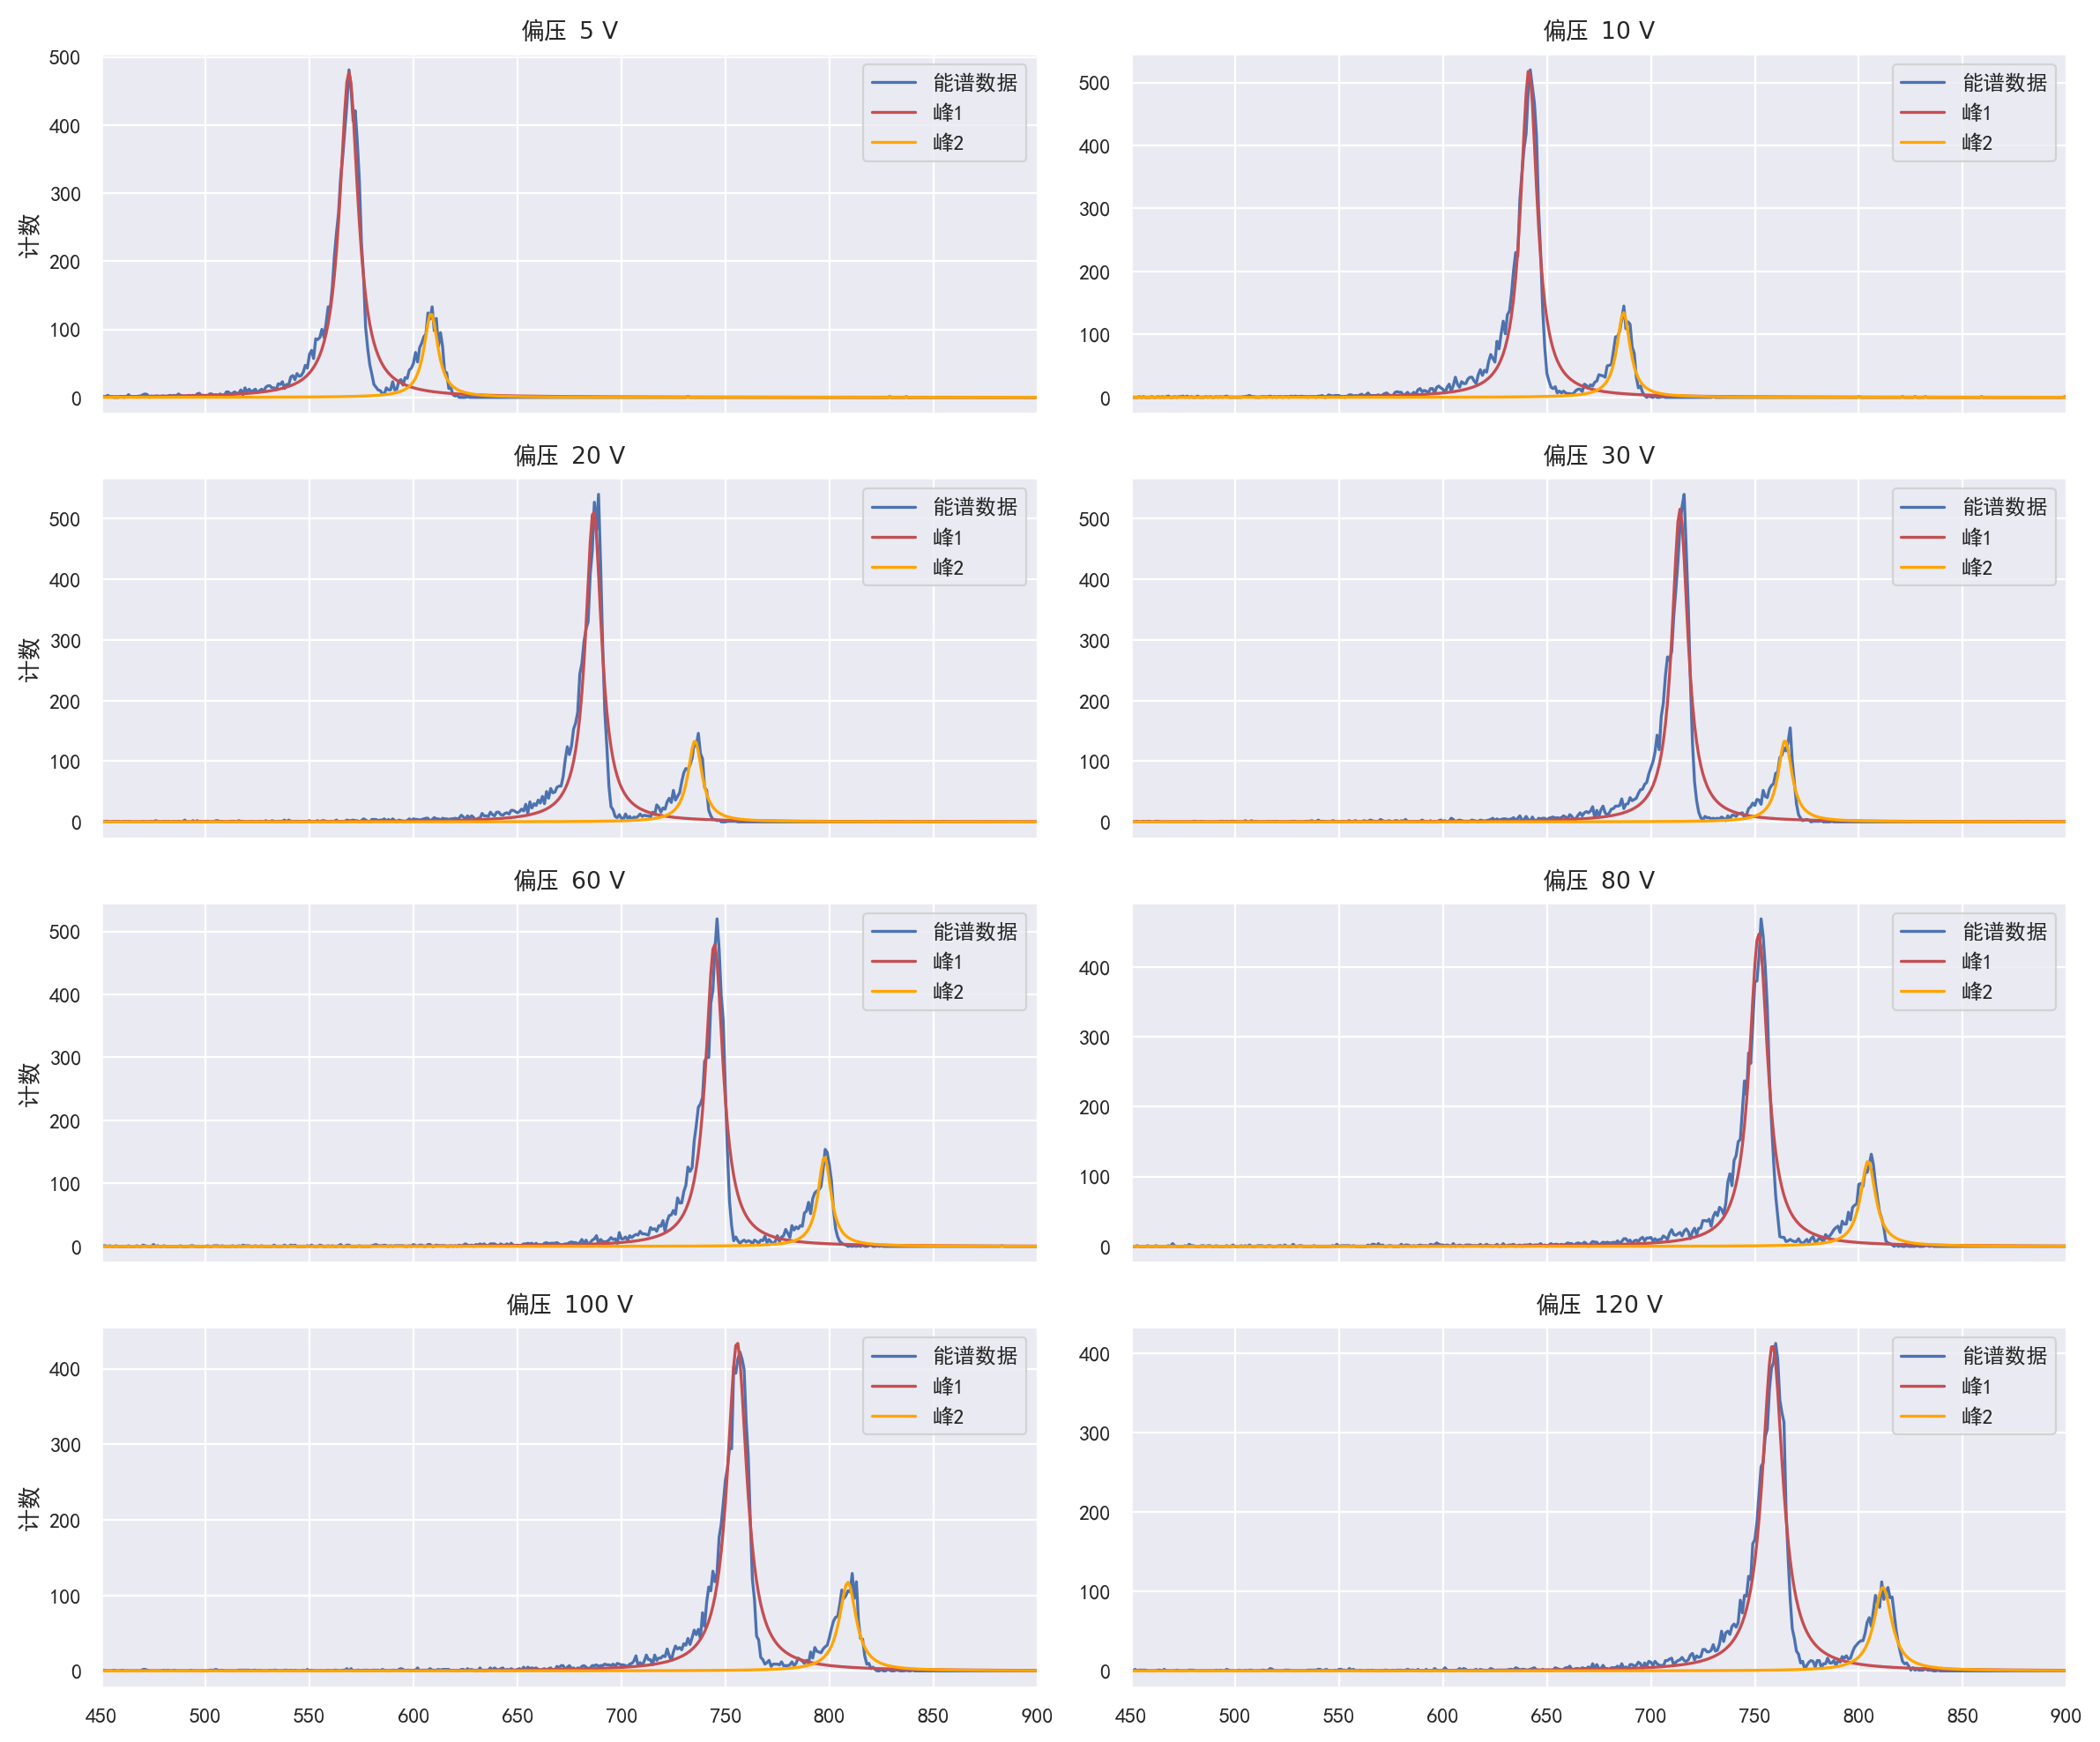

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from lmfit.models import GaussianModel, LorentzianModel

axes = data1.plot(subplots=True,layout=(4,2),figsize=(12,10),color = 'b')
axes = axes.flatten()
axes[0].set_xlim([450,900])

axes1 = data1.plot(subplots=True, layout=(4, 2), figsize=(12, 10), color='b')
axes1 = axes1.flatten()
axes1[0].set_xlim([450, 900])

axes2 = data1.plot(subplots=True, layout=(4, 2), figsize=(12, 10), color='b')
axes2 = axes2.flatten()
axes2[0].set_xlim([450, 900])

peaks = []
widths = []

gauss_peaks = []
gauss_widths = []

lorentz_peaks = []
lorentz_widths = []

for i, (col,ax, ax1, ax2) in enumerate(zip(data1.columns,axes, axes1, axes2)):
    # peak analysis
    peak, info = find_peaks(data1[col], height=100, width=8)
    peaks.append(peak[0])
    widths.append(info['widths'][0])
    
    ax.scatter(peak,data1[col][peak],marker='x',s=50,color='r',label='peak')
    ax.scatter(info['left_ips'],info['width_heights'],s=10,color='r')
    ax.scatter(info['right_ips'],info['width_heights'],s=10,color='r')
    ax.hlines(info['width_heights'],info['left_ips'],info['right_ips'],
              linestyles = 'dashed',color='r',label = 'FWHM')
    ax.legend(['能谱数据','峰值','半峰宽'])
    ax.set_title(fr'偏压 ${col}~{{\rm V}}$')
    if i%2 == 0:
        ax.set_ylabel('计数')

    # Gaussian analysis
    gauss1 = GaussianModel(prefix='g1_')
    pars = gauss1.make_params(center=peak[0],
                              sigma=info['widths'][0] / 2.3548200,
                              amplitude=info['peak_heights'][0] / 0.3989423 * (info['widths'][0] / 2.3548200))

    gauss2 = GaussianModel(prefix='g2_')
    pars.update(gauss2.make_params(center=peak[1],
                                   sigma=info['widths'][1] / 2.3548200,
                                   amplitude=info['peak_heights'][1] / 0.3989423 * (info['widths'][1] / 2.3548200)))
    mod = gauss1 + gauss2
    out = mod.fit(data1[col].values, pars, x=data1.index.values)
    comps = out.eval_components(x=data1.index.values)

    ax1.plot(data1.index.values, comps['g1_'], label='Gaussian component 1', color='r')
    ax1.plot(data1.index.values, comps['g2_'], label='Gaussian component 2', color='orange')
    # print(out.fit_report(correl_mode='table'))
    gauss_peaks.append(out.params['g1_center'].value)
    gauss_widths.append(out.params['g1_fwhm'].value)
    ax1.legend(['能谱数据','峰1','峰2'])
    ax1.set_title(fr'偏压 ${col}~{{\rm V}}$')
    if i%2 == 0:
        ax1.set_ylabel('计数')

    # Lorentzian analysis
    lorentz1 = LorentzianModel(prefix='l1_')
    lorentz_pars = lorentz1.make_params(center=peak[0],
                                        sigma=info['widths'][0] / 2,
                                        amplitude=info['peak_heights'][0] / 0.3989423*(info['widths'][0] / 2))

    lorentz2 = LorentzianModel(prefix='l2_')
    lorentz_pars.update(lorentz2.make_params(center=peak[1],
                                             sigma=info['widths'][1] / 2,
                                             amplitude=info['peak_heights'][1] / 0.3989423*(info['widths'][0] / 2)))
    lorentz_mod = lorentz1 + lorentz2
    lorentz_out = lorentz_mod.fit(data1[col].values, lorentz_pars, x=data1.index.values)
    lorentz_comps = lorentz_out.eval_components(x=data1.index.values)

    ax2.plot(data1.index.values, lorentz_comps['l1_'], label='Lorentzian component 1',color='r')
    ax2.plot(data1.index.values, lorentz_comps['l2_'], label='Lorentzian component 2',color='orange')
    lorentz_peaks.append(lorentz_out.params['l1_center'].value)
    lorentz_widths.append(lorentz_out.params['l1_fwhm'].value)
    ax2.legend(['能谱数据','峰1','峰2'])
    ax2.set_title(fr'偏压 ${col}~{{\rm V}}$')
    if i%2 == 0:
        ax2.set_ylabel('计数')

fig = axes[0].get_figure()
fig1 = axes1[0].get_figure()
fig2 = axes2[0].get_figure()
fig.tight_layout()
fig1.tight_layout()
fig2.tight_layout()
fig.savefig(path+'plain_volt.pdf')
fig1.savefig(path+'gauss_volt.pdf')
fig2.savefig(path+'lorentz_volt.pdf')

# fig.savefig(path+'best_volt.pdf')

In [7]:
result1 = pd.DataFrame({'Volt':data1.columns.values,
                        'peak':peaks,
                        'width':widths,
                        'gauss_peak':gauss_peaks,
                        'gauss_width':gauss_widths,
                        'lorentz_peak':lorentz_peaks,
                        'lorentz_width':lorentz_widths})

result1['resolution'] = result1['width']/result1['peak']
result1['gauss_resolution'] = result1['gauss_width']/result1['gauss_peak']
result1['lorentz_resolution'] = result1['lorentz_width']/result1['lorentz_peak']

result1 = result1.reindex(columns=['Volt','peak','width','resolution',
                         'gauss_peak','gauss_width','gauss_resolution',
                         'lorentz_peak','lorentz_width','lorentz_resolution'])
result1

,Volt,peak,width,resolution,gauss_peak,gauss_width,gauss_resolution,lorentz_peak,lorentz_width,lorentz_resolution
0,5,569,11.886509,0.020890,568.765824,13.291649,0.023369,568.967376,10.820932,0.019019
1,10,642,10.157143,0.015821,641.049904,11.988864,0.018702,641.368684,9.688811,0.015106
2,20,689,9.951835,0.014444,686.094614,11.894141,0.017336,686.612601,9.429511,0.013733
3,30,716,9.425000,0.013163,713.384723,12.040941,0.016879,713.978223,9.405138,0.013173
4,60,746,10.476115,0.014043,744.053888,13.130710,0.017648,744.709366,10.266047,0.013785
5,80,753,10.825521,0.014377,751.267296,13.633388,0.018147,751.800755,10.785868,0.014347
6,100,757,13.231938,0.017479,755.167051,14.347580,0.018999,755.612293,11.494697,0.015212
7,120,760,13.421107,0.017659,758.107908,14.948325,0.019718,758.520120,12.139658,0.016004


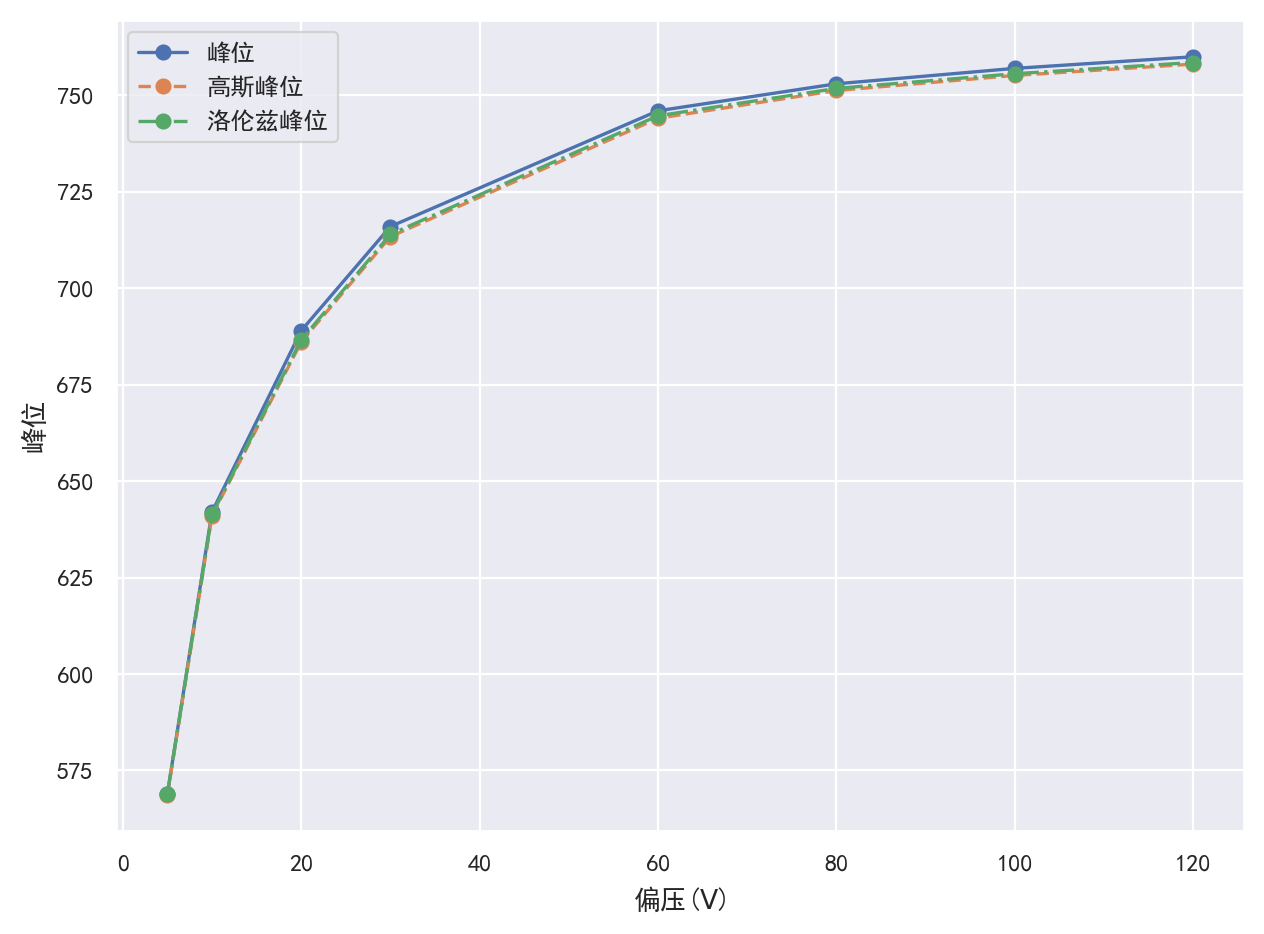

In [8]:
ax = result1.plot(x='Volt',y=['peak','gauss_peak','lorentz_peak'],style=['o-','o--','o-.'],legend=True)
ax.legend(['峰位', '高斯峰位', '洛伦兹峰位'])

# 添加轴标题
ax.set_xlabel(r'偏压($\mathrm{V}$)')
ax.set_ylabel('峰位')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(path+'peak_position.pdf')

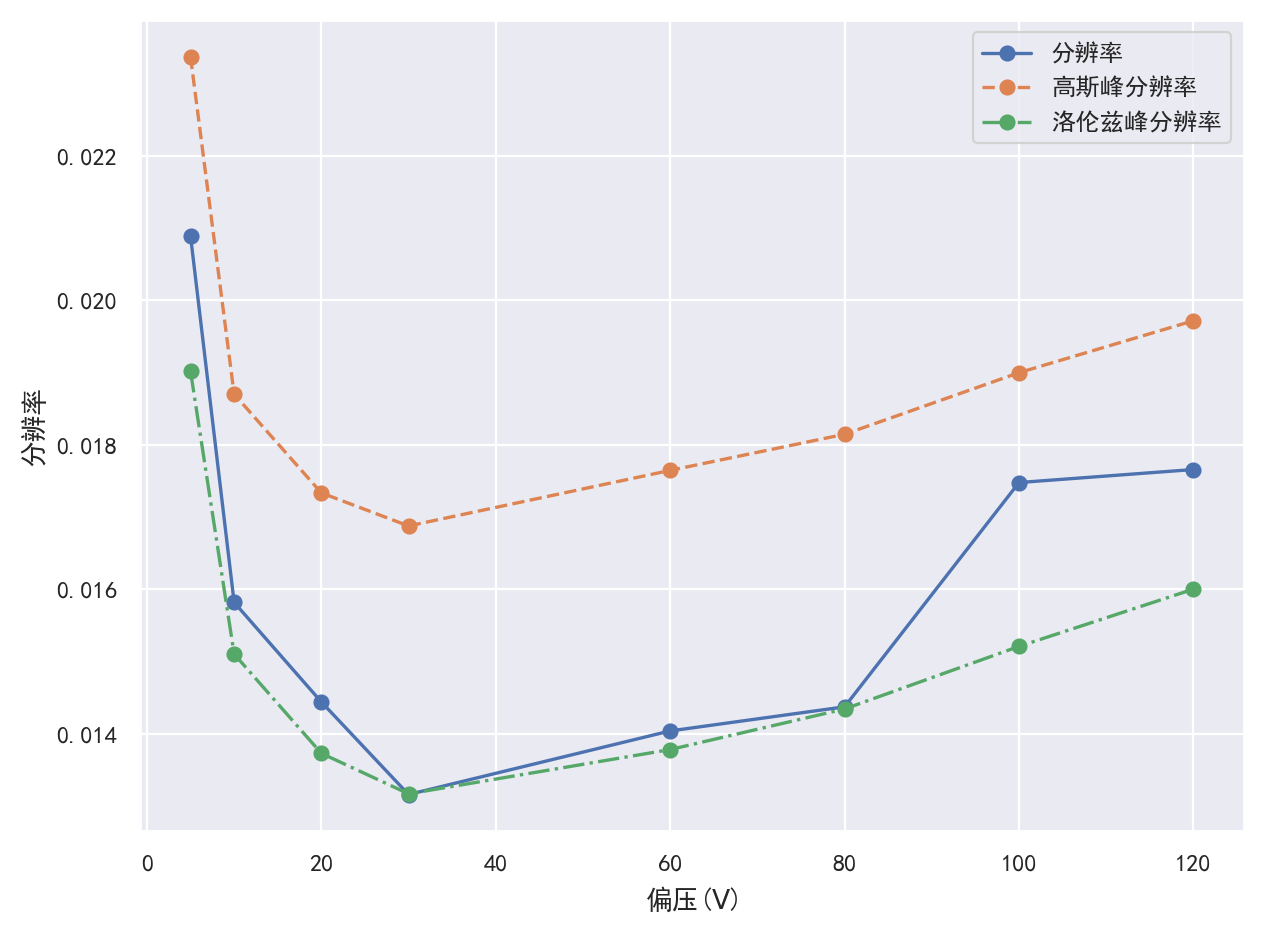

In [9]:
ax = result1.plot(x='Volt',y=['resolution','gauss_resolution','lorentz_resolution'],style=['o-','o--','o-.'],legend=True)
ax.legend(['分辨率', '高斯峰分辨率', '洛伦兹峰分辨率'])

# 添加轴标题
ax.set_xlabel(r'偏压($\mathrm{V}$)')
ax.set_ylabel('分辨率')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(path+'resolution.pdf')

# 射程和能量

## 谱数据

In [10]:
datapath ='./data/zzxcarry/'
files = os.listdir(datapath)

txtfiles = []
for file in files:
    _,extension= os.path.splitext(file)
    if extension=='.txt':
        txtfiles.append(file)

# txtfiles.sort(key = lambda x:eval(os.path.splitext(x)[0]))
txtfiles.remove('0-07.txt')
txtfiles.remove('0-08.txt')
txtfiles

['0-02.txt',
 '0-03.txt',
 '0-04.txt',
 '0-05.txt',
 '0-06.txt',
 '0-070.txt',
 '0-080.txt',
 '0-09.txt']

In [11]:
data_dict = {os.path.splitext(txtfile)[0]:pd.read_csv(datapath+txtfile, sep='\t')['1'].values \
             for txtfile in txtfiles}
data2 = pd.DataFrame(data_dict)
data2.columns=[round(0.1-eval(i.replace('-','.')),2) for i in data2.columns]
data2.drop(columns=0.08, axis=0, inplace=True)
data2

,0.07,0.06,0.05,0.04,0.03,0.02,0.01
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1019,0,0,0,0,0,0,0
1020,0,0,0,0,0,0,0
1021,0,0,0,0,0,0,0
1022,0,0,0,0,0,0,0


array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

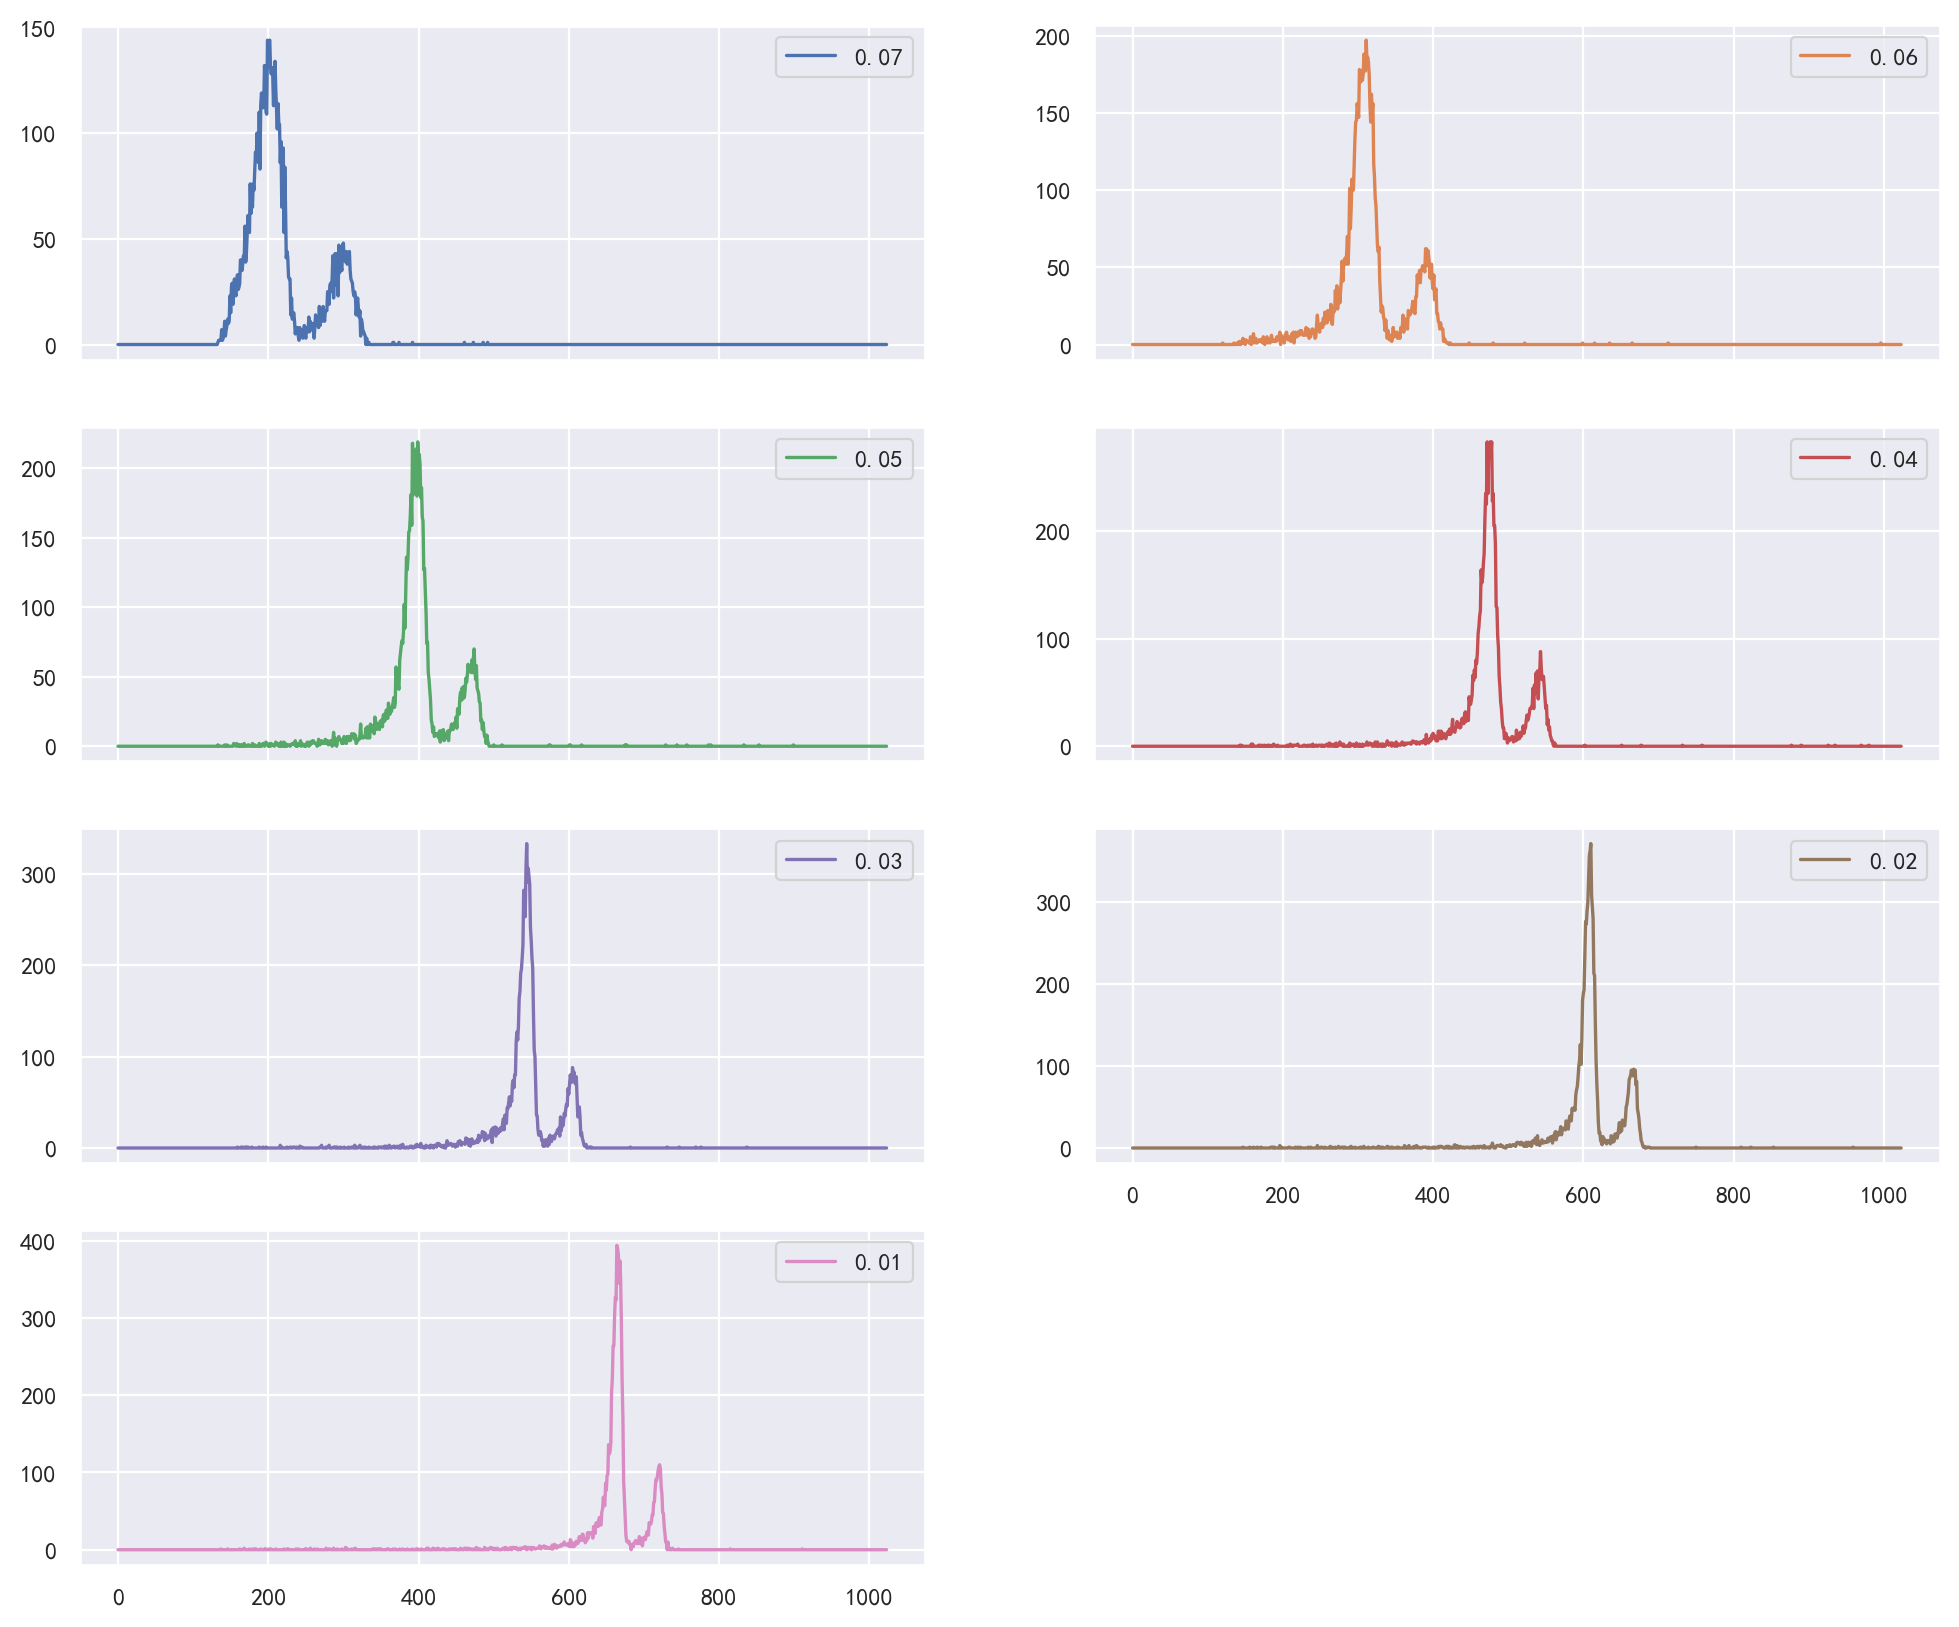

In [12]:
data2.plot(subplots=True, layout=(4, 2), figsize=(12, 10))

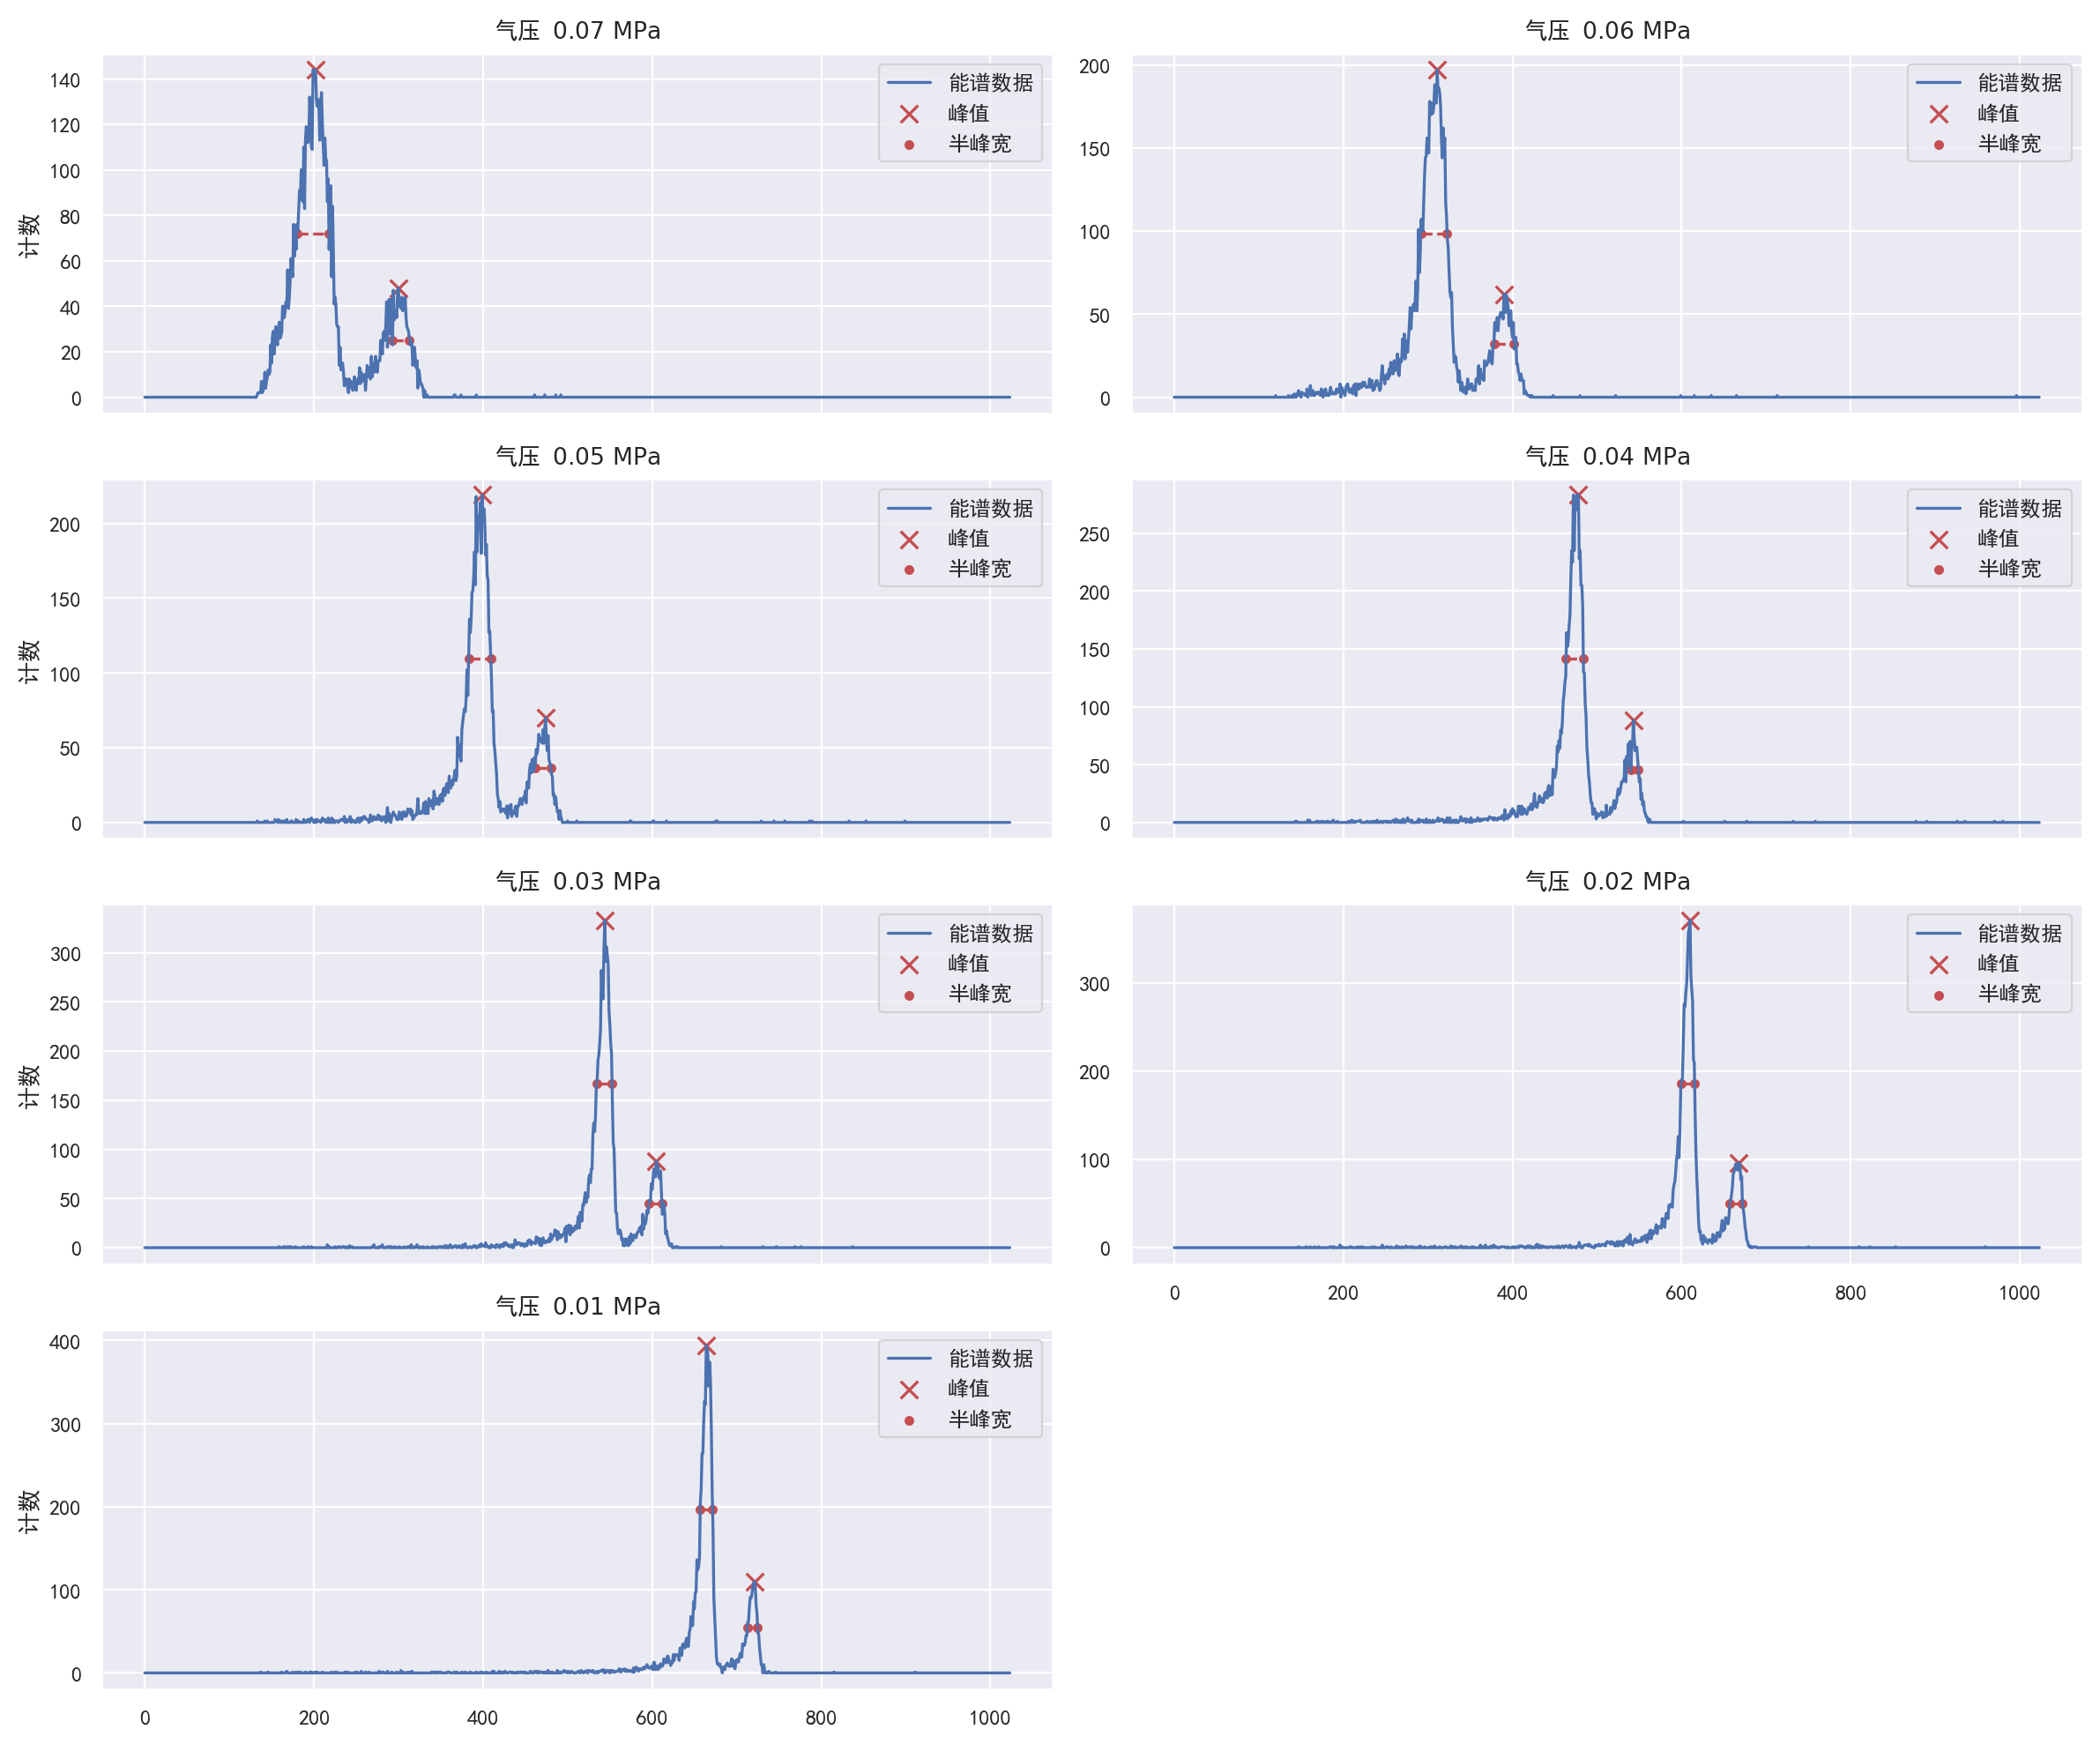

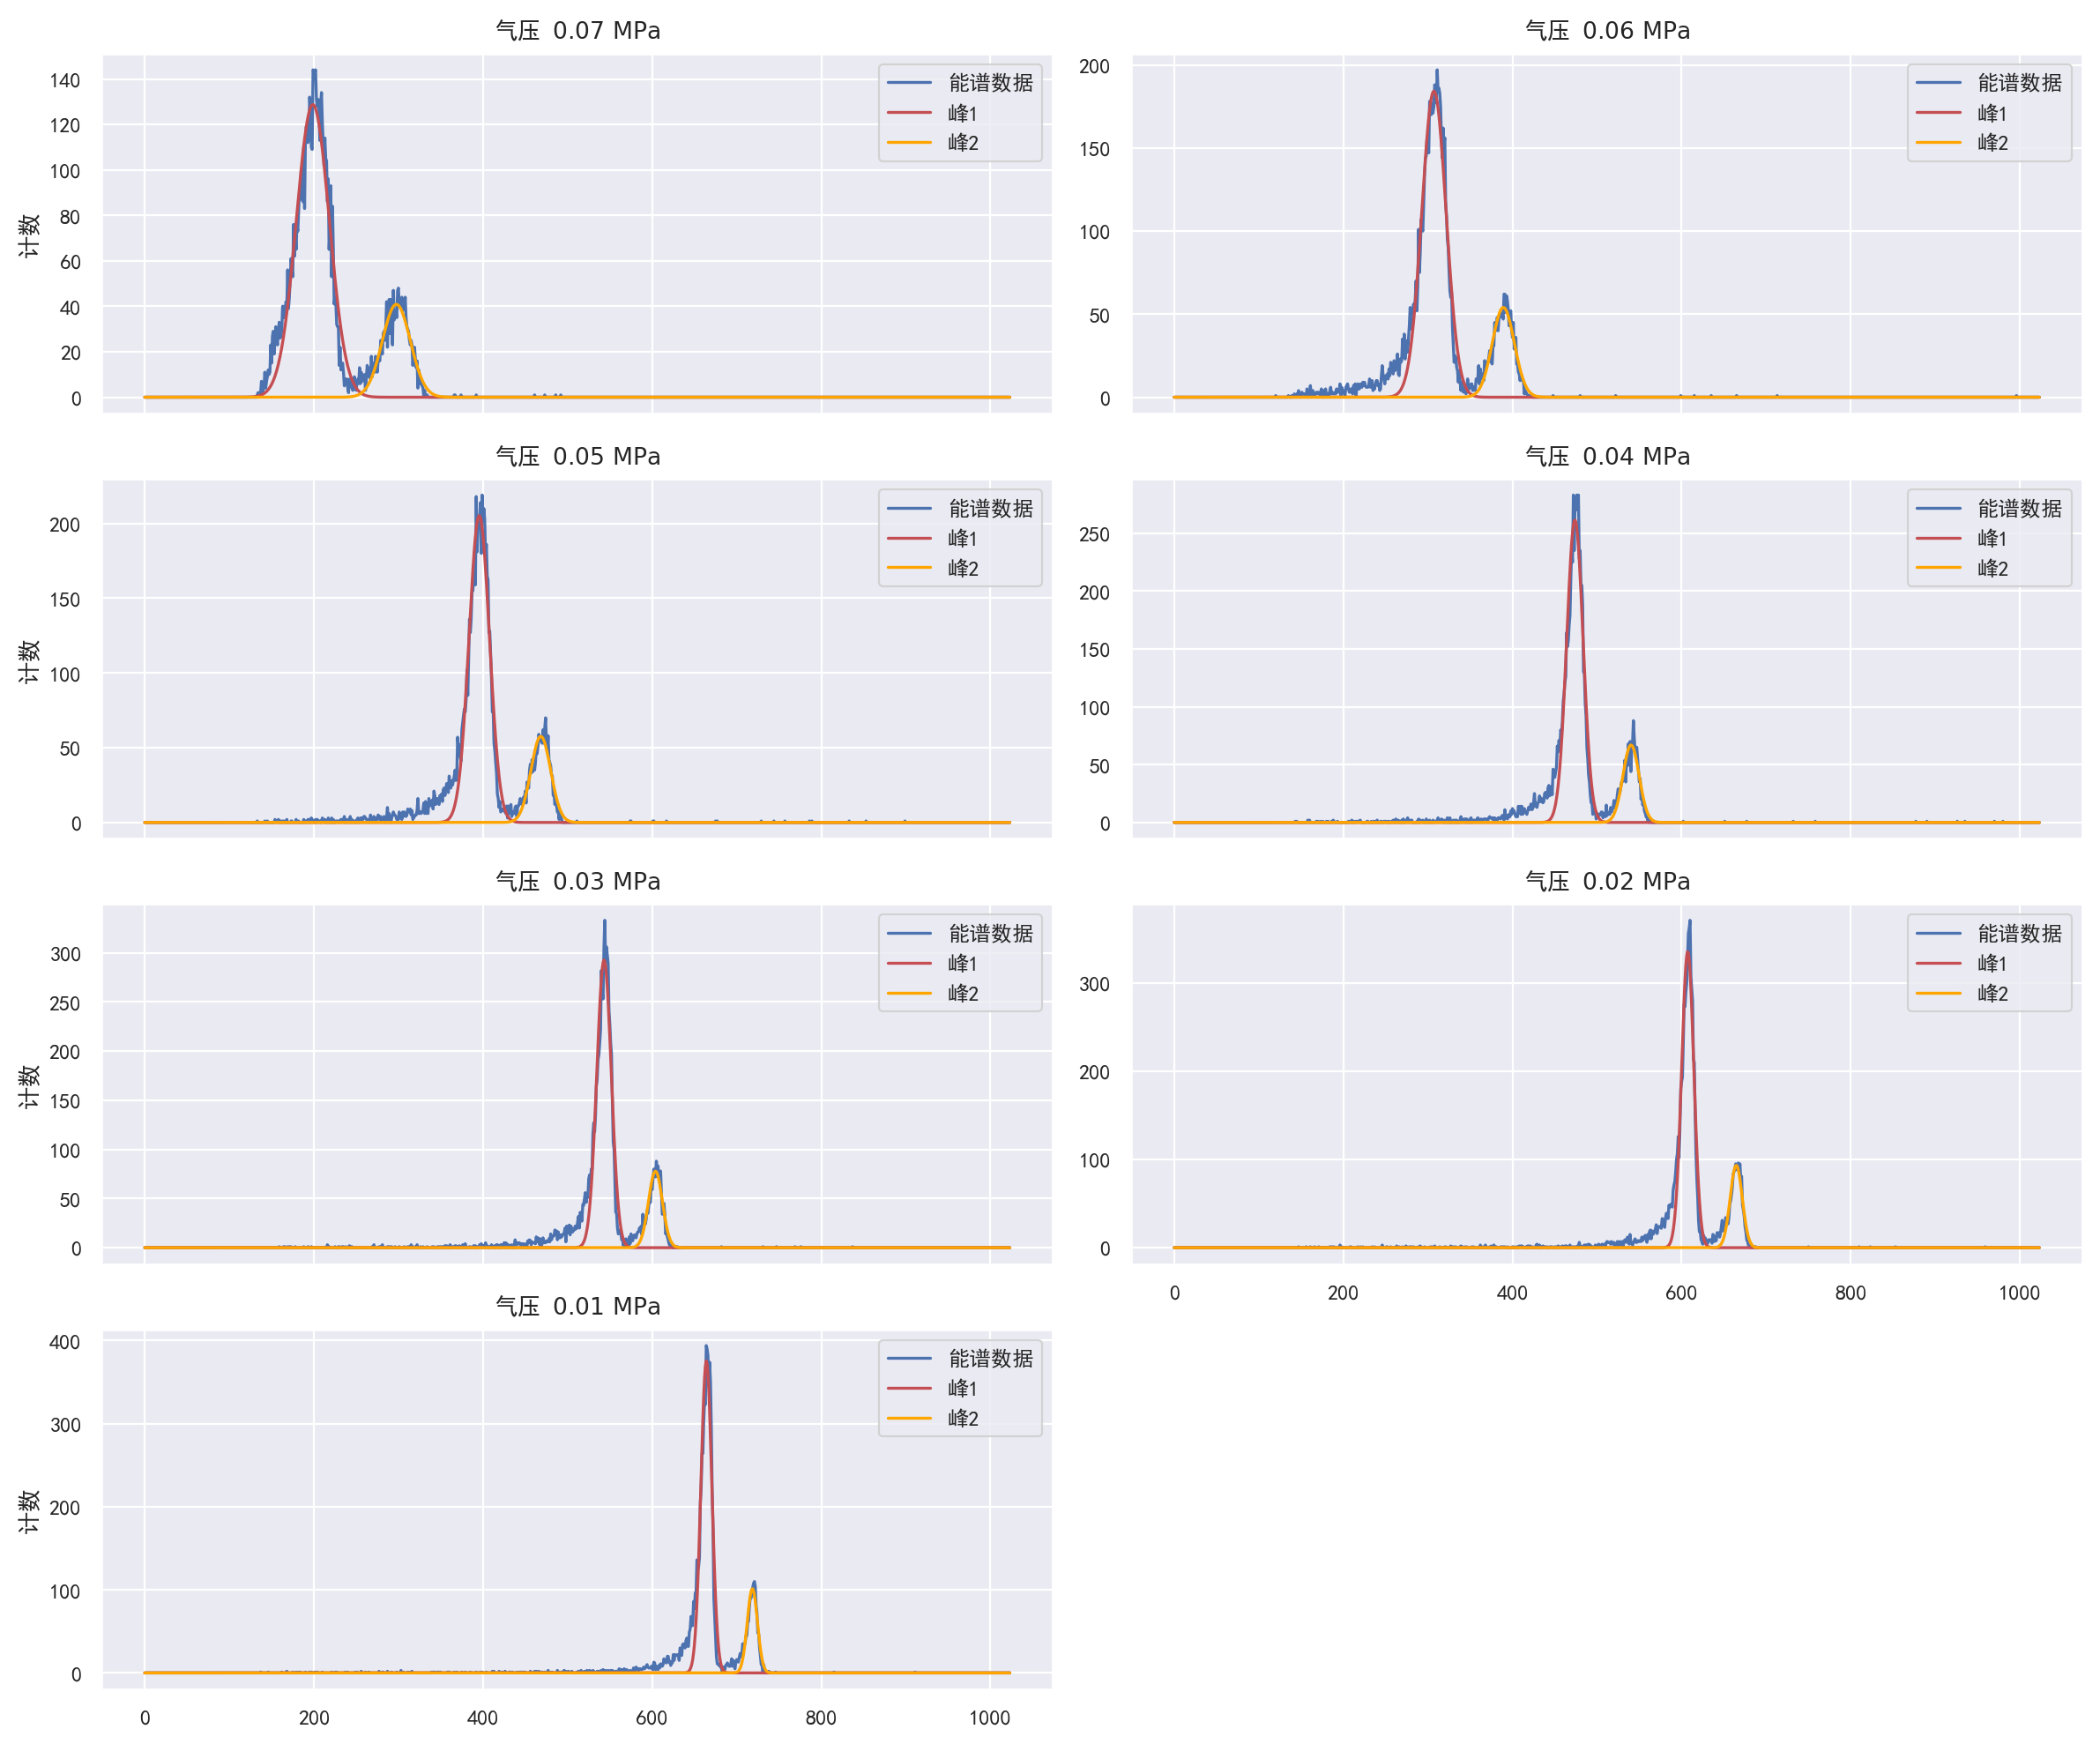

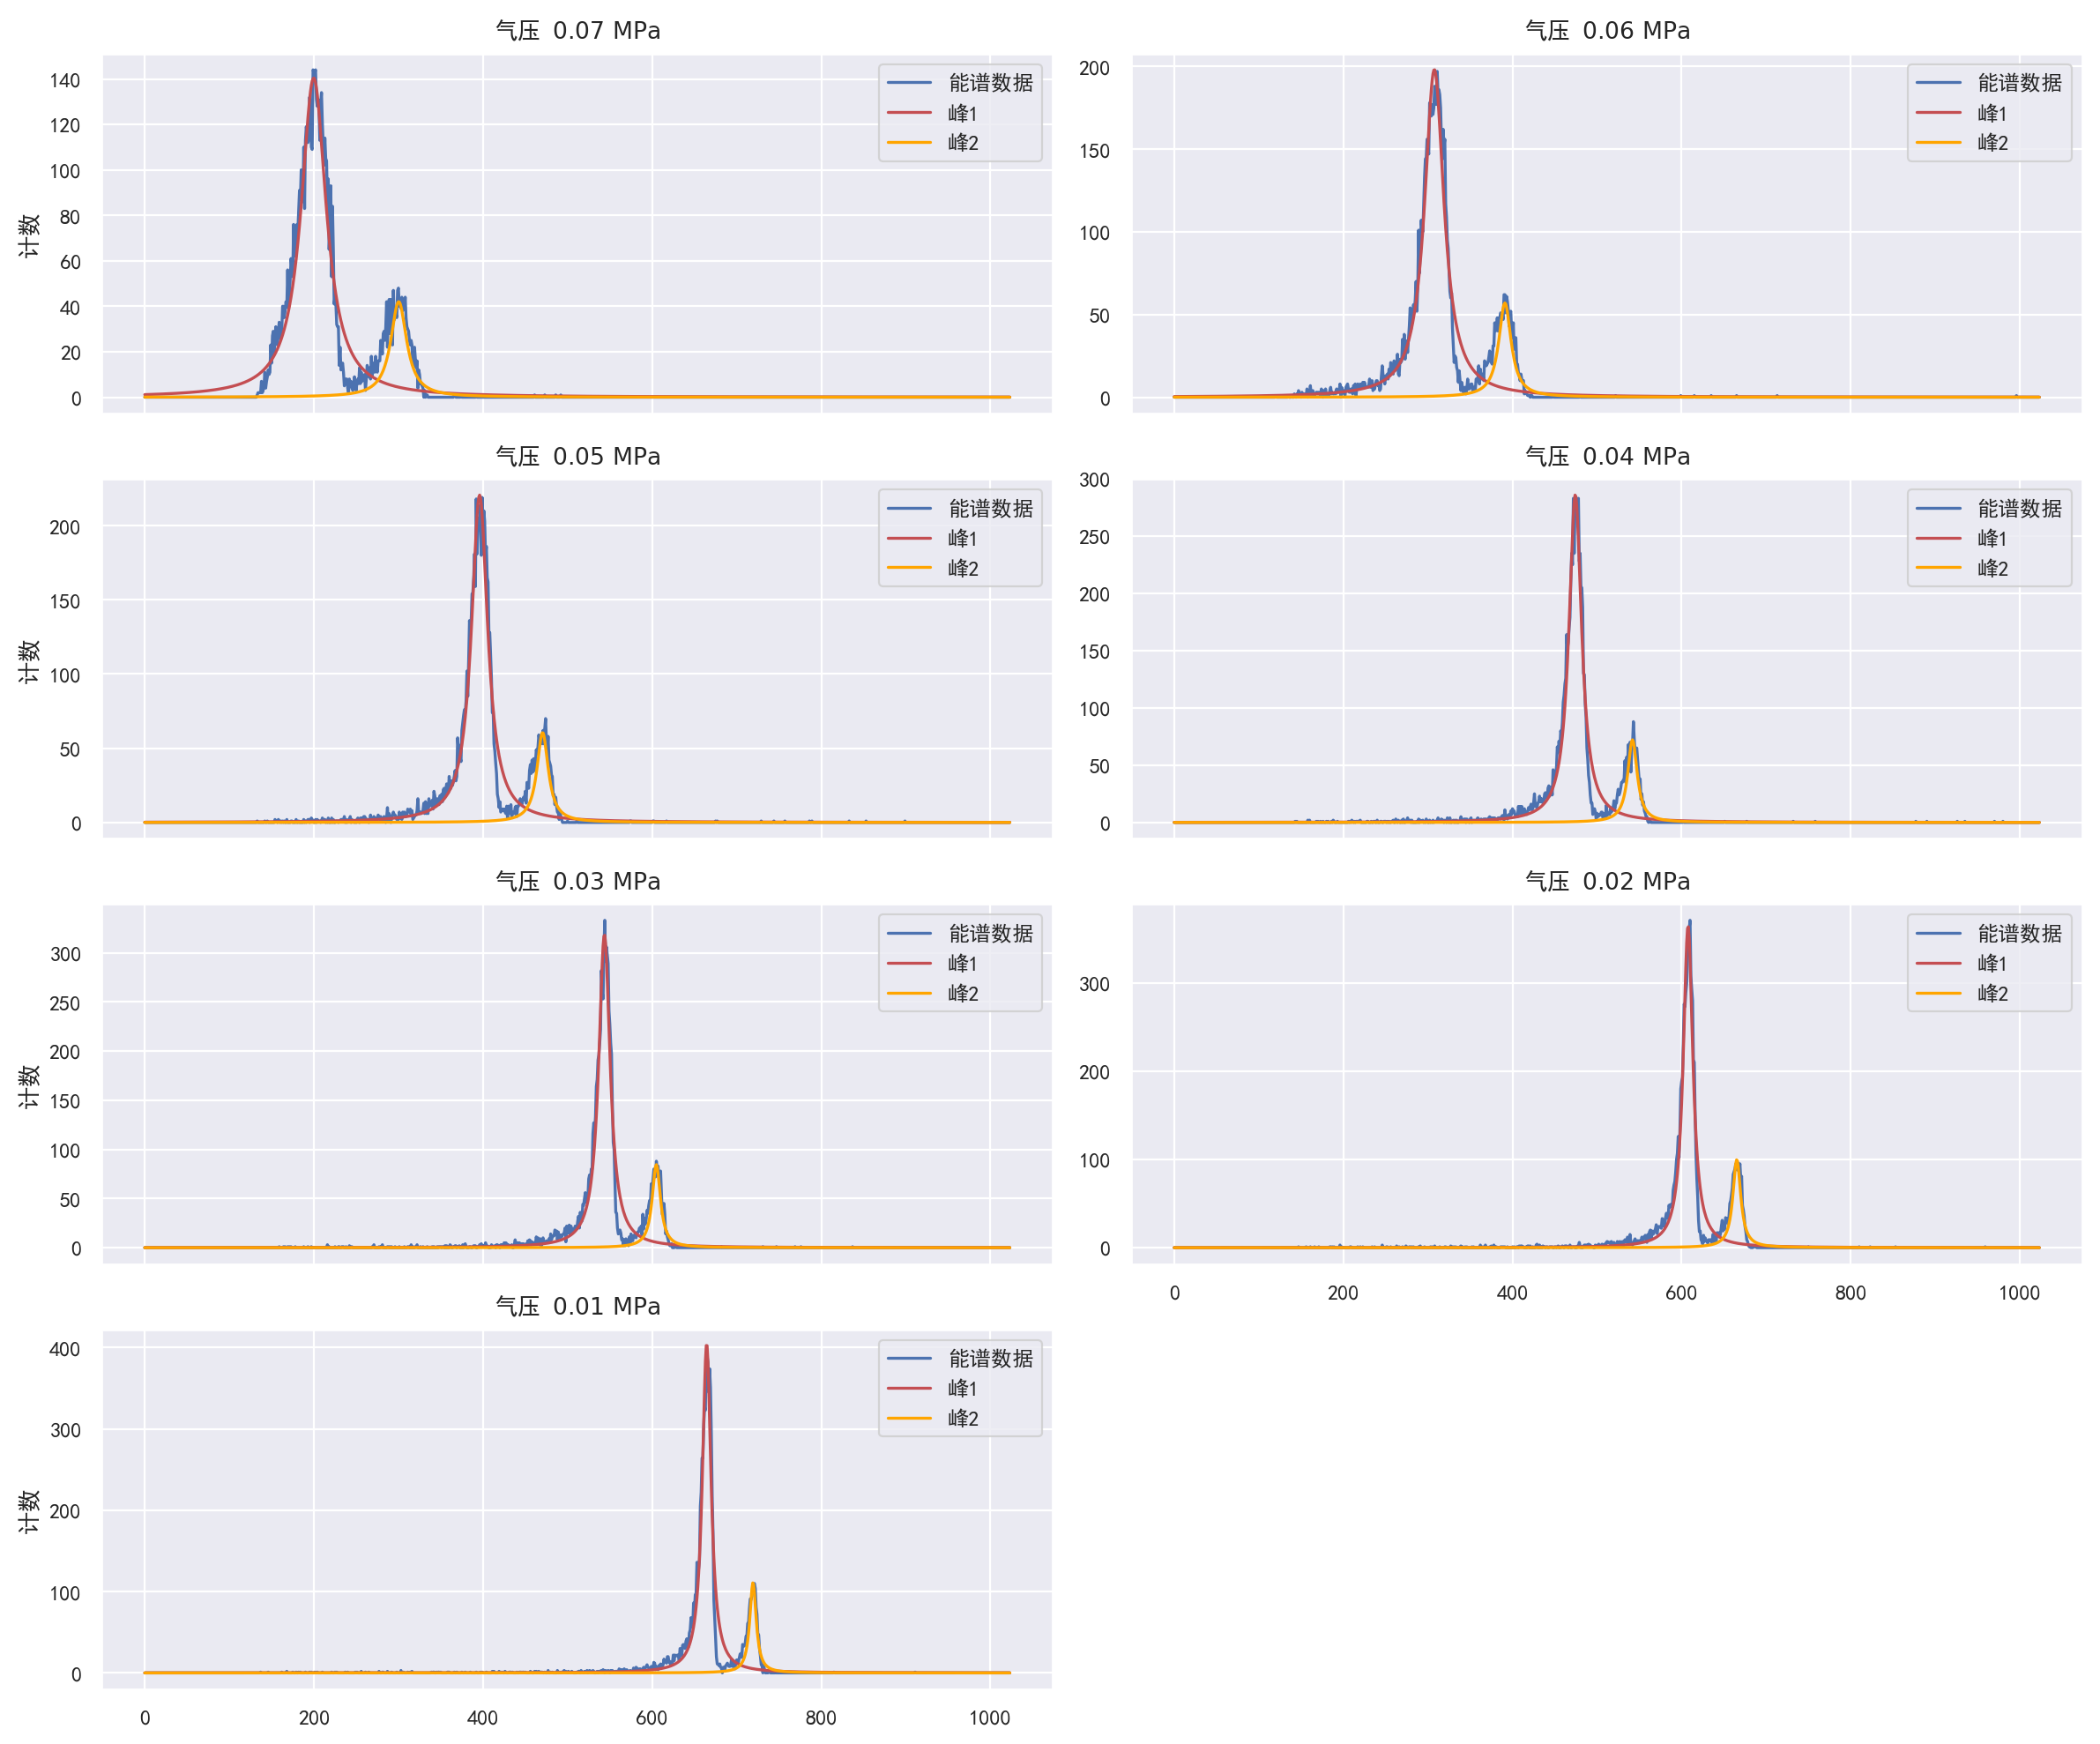

In [13]:
axes = data2.plot(subplots=True,layout=(4,2),figsize=(12,10),color = 'b')
axes = axes.flatten()


axes1 = data2.plot(subplots=True, layout=(4, 2), figsize=(12, 10), color='b')
axes1 = axes1.flatten()


axes2 = data2.plot(subplots=True, layout=(4, 2), figsize=(12, 10), color='b')
axes2 = axes2.flatten()

peaks = []
widths = []

gauss_peaks = []
gauss_widths = []

lorentz_peaks = []
lorentz_widths = []


for i, (col,ax, ax1, ax2) in enumerate(zip(data2.columns,axes, axes1, axes2)):
    # peak analysis
    # print(peak)
    if i==0:
        peak, info = find_peaks(data2[col],height = 10, width=10,distance=50)
    else:
        peak, info = find_peaks(data2[col], height=50, width=8,distance=50)
    peaks.append(peak[0])
    widths.append(info['widths'][0])
    
    ax.scatter(peak,data2[col][peak],marker='x',s=50,color='r',label='peak')
    ax.scatter(info['left_ips'],info['width_heights'],s=10,color='r')
    ax.scatter(info['right_ips'],info['width_heights'],s=10,color='r')
    ax.hlines(info['width_heights'],info['left_ips'],info['right_ips'],
              linestyles = 'dashed',color='r',label = 'FWHM')
    ax.legend(['能谱数据','峰值','半峰宽'])
    ax.set_title(fr'气压 ${col}~{{\rm MPa}}$')
    if i%2 == 0:
        ax.set_ylabel('计数')

    # Gaussian analysis
    gauss1 = GaussianModel(prefix='g1_')
    pars = gauss1.make_params(center=peak[0],
                              sigma=info['widths'][0] / 2.3548200,
                              amplitude=info['peak_heights'][0] / 0.3989423 * (info['widths'][0] / 2.3548200))

    gauss2 = GaussianModel(prefix='g2_')
    pars.update(gauss2.make_params(center=peak[1],
                                   sigma=info['widths'][1] / 2.3548200,
                                   amplitude=info['peak_heights'][1] / 0.3989423 * (info['widths'][1] / 2.3548200)))
    mod = gauss1 + gauss2
    out = mod.fit(data2[col].values, pars, x=data2.index.values)
    comps = out.eval_components(x=data2.index.values)

    ax1.plot(data2.index.values, comps['g1_'], label='Gaussian component 1', color='r')
    ax1.plot(data2.index.values, comps['g2_'], label='Gaussian component 2', color='orange')
    # print(out.fit_report(correl_mode='table'))
    gauss_peaks.append(out.params['g1_center'].value)
    gauss_widths.append(out.params['g1_fwhm'].value)
    ax1.legend(['能谱数据','峰1','峰2'])
    ax1.set_title(fr'气压 ${col}~{{\rm MPa}}$')
    if i%2 == 0:
        ax1.set_ylabel('计数')

    # Lorentzian analysis
    lorentz1 = LorentzianModel(prefix='l1_')
    lorentz_pars = lorentz1.make_params(center=peak[0],
                                        sigma=info['widths'][0] / 2,
                                        amplitude=info['peak_heights'][0] / 0.3989423*(info['widths'][0] / 2))

    lorentz2 = LorentzianModel(prefix='l2_')
    lorentz_pars.update(lorentz2.make_params(center=peak[1],
                                             sigma=info['widths'][1] / 2,
                                             amplitude=info['peak_heights'][1] / 0.3989423*(info['widths'][0] / 2)))
    lorentz_mod = lorentz1 + lorentz2
    lorentz_out = lorentz_mod.fit(data2[col].values, lorentz_pars, x=data2.index.values)
    lorentz_comps = lorentz_out.eval_components(x=data2.index.values)

    ax2.plot(data2.index.values, lorentz_comps['l1_'], label='Lorentzian component 1',color='r')
    ax2.plot(data2.index.values, lorentz_comps['l2_'], label='Lorentzian component 2',color='orange')
    lorentz_peaks.append(lorentz_out.params['l1_center'].value)
    lorentz_widths.append(lorentz_out.params['l1_fwhm'].value)
    ax2.legend(['能谱数据','峰1','峰2'])
    ax2.set_title(fr'气压 ${col}~{{\rm MPa}}$')
    if i%2 == 0:
        ax2.set_ylabel('计数')

fig = axes[0].get_figure()
fig1 = axes1[0].get_figure()
fig2 = axes2[0].get_figure()
fig.tight_layout()
fig1.tight_layout()
fig2.tight_layout()
fig.savefig(path+'plain_volt_diffpressure.pdf')
fig1.savefig(path+'gauss_volt_diffpressure.pdf')
fig2.savefig(path+'lorentz_volt_diffpressure.pdf')

# fig.savefig(path+'best_volt.pdf')

In [14]:
result2 = pd.DataFrame({'Pressure':data2.columns.values,
                        'peak':peaks,
                        'width':widths,
                        'gauss_peak':gauss_peaks,
                        'gauss_width':gauss_widths,
                        'lorentz_peak':lorentz_peaks,
                        'lorentz_width':lorentz_widths})

result2['resolution'] = result2['width']/result2['peak']
result2['gauss_resolution'] = result2['gauss_width']/result2['gauss_peak']
result2['lorentz_resolution'] = result2['lorentz_width']/result2['lorentz_peak']

result2 = result2.reindex(columns=['Pressure','peak','width','resolution',
                         'gauss_peak','gauss_width','gauss_resolution',
                         'lorentz_peak','lorentz_width','lorentz_resolution'])
result2

,Pressure,peak,width,resolution,gauss_peak,gauss_width,gauss_resolution,lorentz_peak,lorentz_width,lorentz_resolution
0,0.07,202,38.137830,0.188801,198.744855,45.941367,0.231158,199.771074,36.201350,0.181214
1,0.06,311,31.197368,0.100313,307.109837,33.869919,0.110286,307.577598,27.745558,0.090207
2,0.05,399,26.200231,0.065665,395.554670,28.387947,0.071767,395.965927,23.337934,0.058939
3,0.04,478,20.393829,0.042665,473.820197,22.765948,0.048048,474.271918,18.202333,0.038380
4,0.03,544,18.252857,0.033553,543.141185,20.224574,0.037236,543.584721,16.309888,0.030004
5,0.02,610,15.734914,0.025795,607.254510,16.989992,0.027978,607.628037,13.759355,0.022644
6,0.01,664,14.599473,0.021987,664.147768,15.179329,0.022855,664.493289,12.464255,0.018758


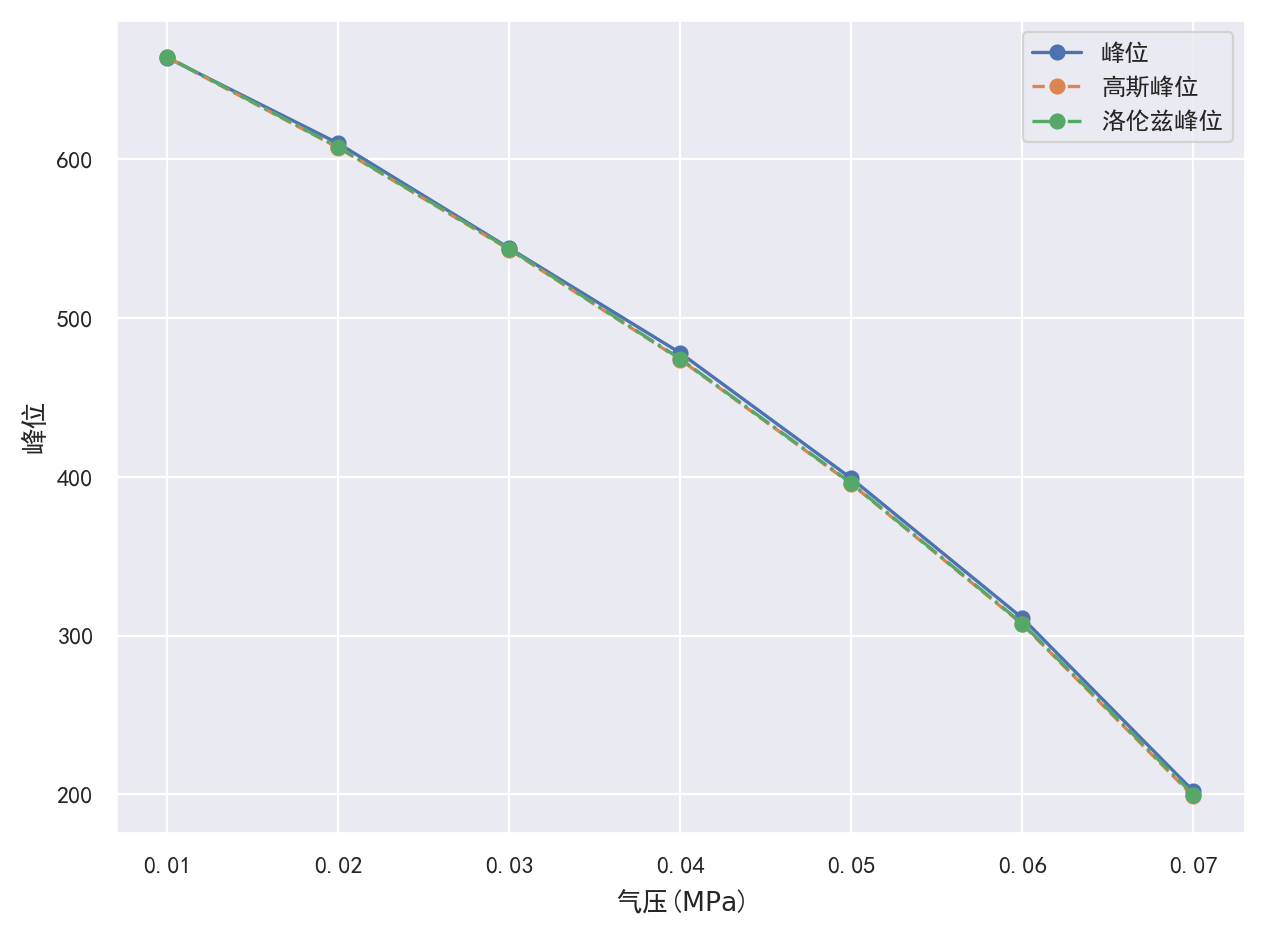

In [15]:
ax = result2.plot(x='Pressure',y=['peak','gauss_peak','lorentz_peak'],style=['o-','o--','o-.'],legend=True)
ax.legend(['峰位', '高斯峰位', '洛伦兹峰位'])

# 添加轴标题
ax.set_xlabel(r'气压($\mathrm{MPa}$)')
ax.set_ylabel('峰位')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(path+'peak_position_diffpressure.pdf')

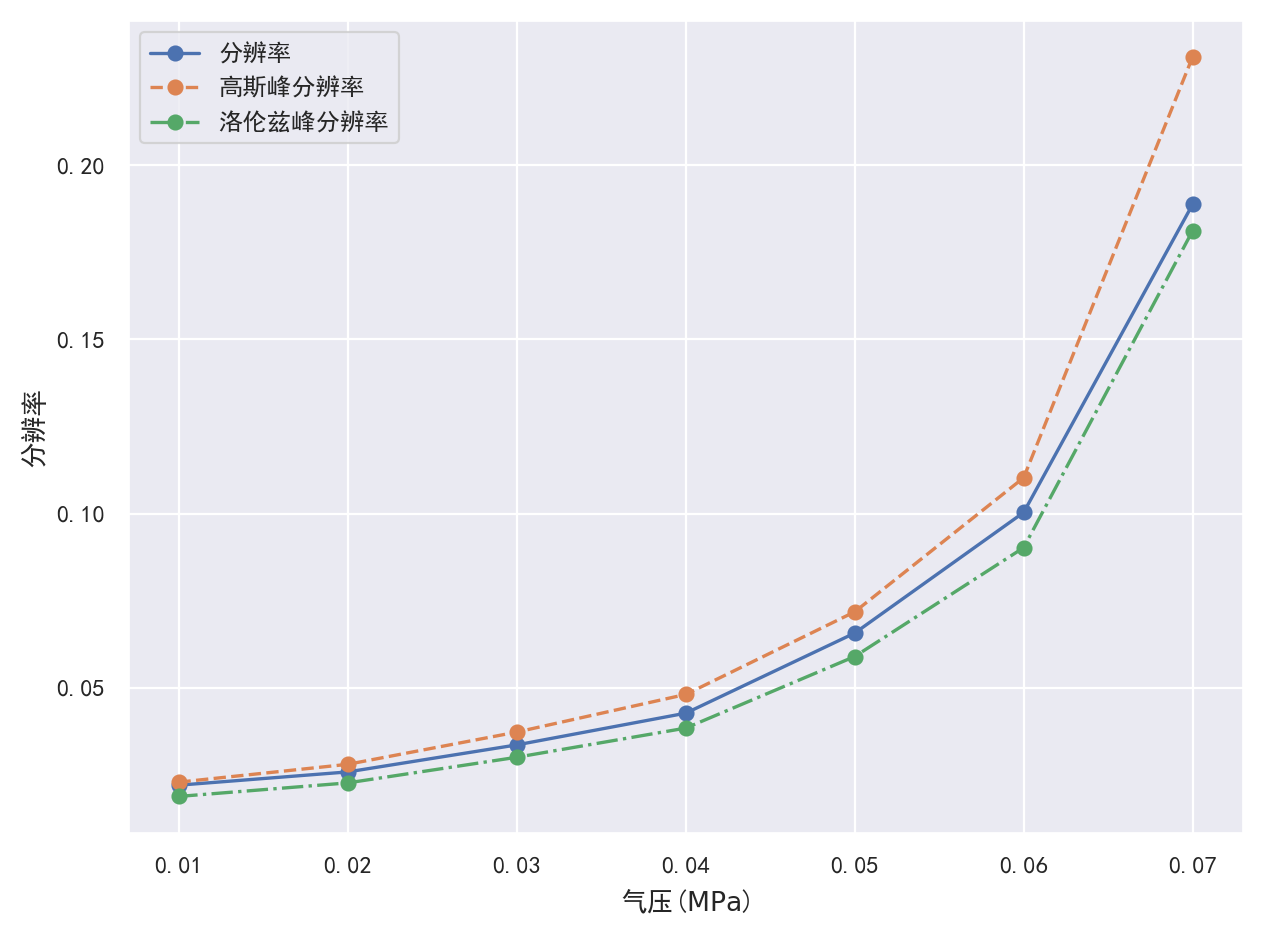

In [16]:
ax = result2.plot(x='Pressure',y=['resolution','gauss_resolution','lorentz_resolution'],style=['o-','o--','o-.'],legend=True)
ax.legend(['分辨率', '高斯峰分辨率', '洛伦兹峰分辨率'])

# 添加轴标题
ax.set_xlabel(r'气压($\mathrm{MPa}$)')
ax.set_ylabel('分辨率')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(path+'resolution_diffpressure.pdf')

## 计数

,pressure_trick,Pressure(MPa),Count,range(cm)
0,0.090,0.010,9409,0.420
1,0.080,0.020,9300,0.840
2,0.070,0.030,9422,1.260
3,0.060,0.040,9309,1.680
4,0.050,0.050,9173,2.100
5,0.040,0.060,9437,2.520
6,0.030,0.070,8955,2.940
7,0.020,0.080,8411,3.360
8,0.018,0.082,7911,3.444
9,0.016,0.084,5386,3.528


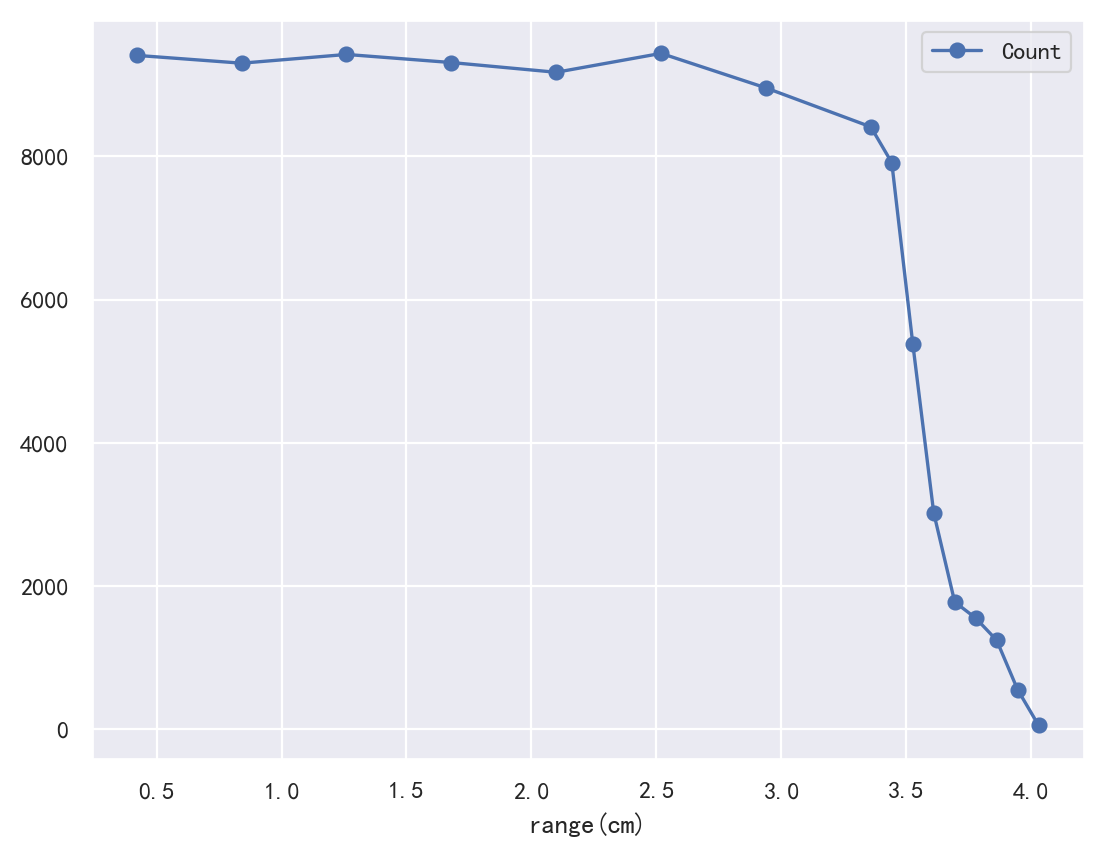

In [17]:
from scipy.interpolate import interp1d

data3 = pd.read_csv('data/alpha_range.csv')
# ax = data3.plot(x='Pressure(MPa)',y='Count')
amp = 0.1
x0 = 4.2
data3['range(cm)'] = data3['Pressure(MPa)']/amp*x0
ax = data3.plot(x='range(cm)',y='Count',style='o-')

height = data3['Count'][:6].mean()

range_curve = interp1d(data3['range(cm)'],data3['Count'])

fig = ax.get_figure()
data3

3.553412013536379


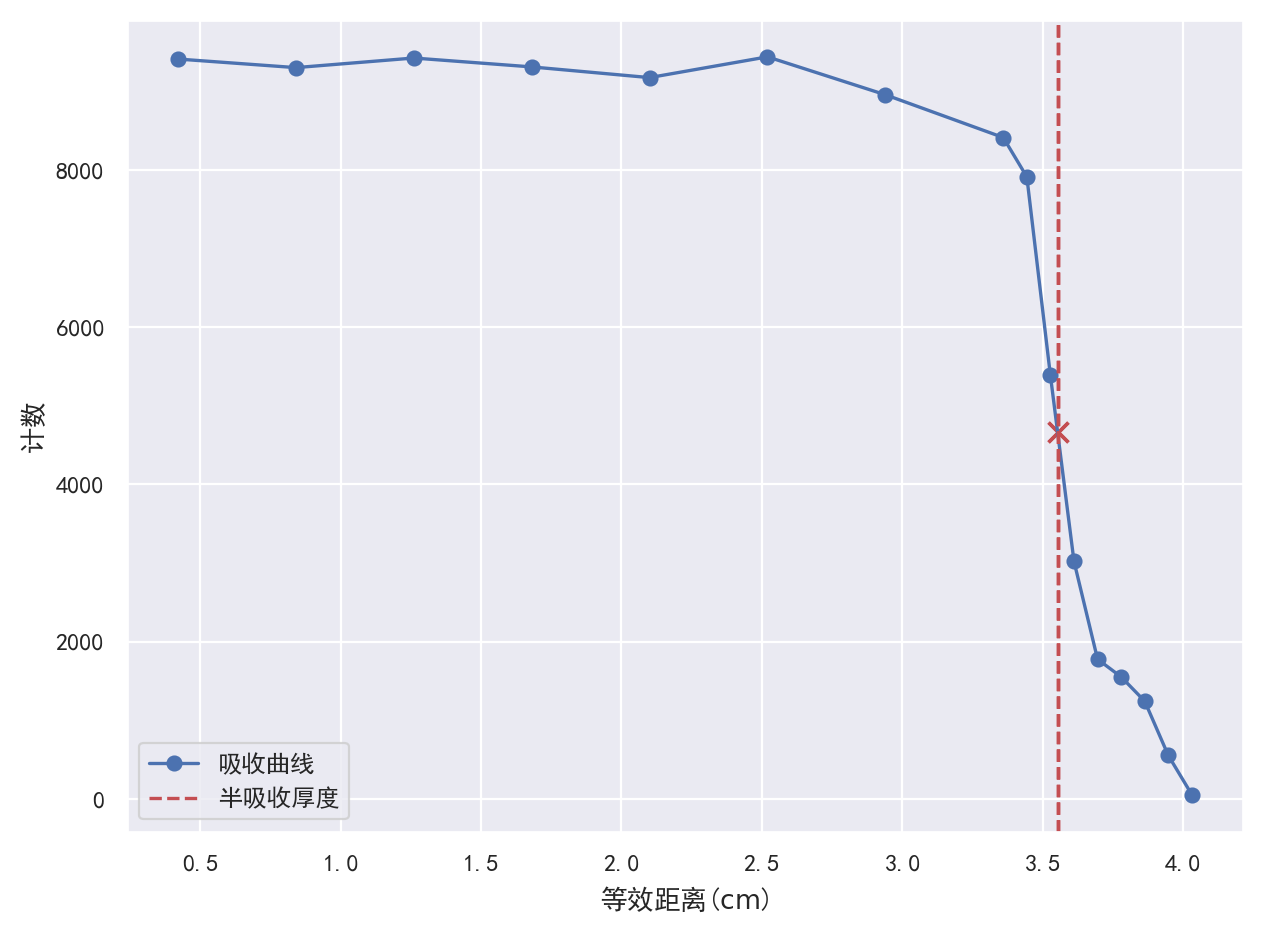

In [20]:
from scipy.optimize import root

def equation_to_solve(x):
    return range_curve(x) - height/2

x_solution = root(equation_to_solve, 3.5)  # 选择一个初始猜测值 x0，例如数据范围内的第一个点
half_range = x_solution.x[0]

# ax.hlines(y=height, xmin=data3['range(cm)'][0], xmax=data3['range(cm)'][5], linestyle='--',color='r')
ax.axvline(half_range, color='r', linestyle='--',label = 'half-absorption')
ax.scatter(half_range, range_curve(half_range),marker = 'x',s = 50, color='r')
ax.set_xlabel(r'等效距离(${\rm cm}$)')
ax.set_ylabel(r'计数')
ax.legend(['吸收曲线','半吸收厚度'])


fig.tight_layout()
fig.savefig(path+'range.pdf')


print(half_range)
fig